In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras import layers
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential, load_model
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
if tf.test.is_built_with_cuda():
    print("=======You can built with CUDA=======")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices()[1].physical_device_desc)
    print("=====================================")
else: 
    print("CUDA not available")

=======You can built with CUDA=======
Num GPUs Available:  1
device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '../../data/landscape_Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../../data/landscape_Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 84%|███████████████████████████████████████████████████████████████▉            | 6000/7129 [00:04<00:00, 1314.42it/s]


In [4]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.title('Цветное изображение', fontsize = 11)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('В серых тонах', fontsize = 11)
    plt.imshow(grayscale)
   
    plt.show()

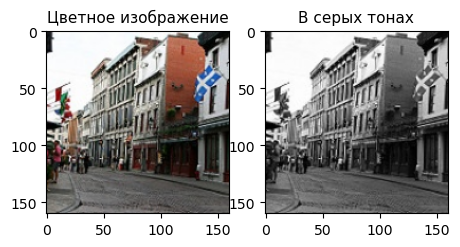

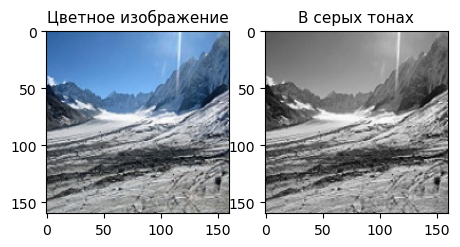

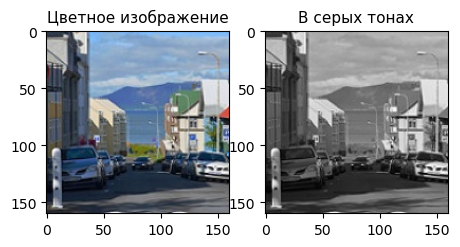

In [5]:
for i in range(3,6):
     plot_images(color_img[i],gray_img[i])

In [6]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [7]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [8]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [11]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class ImageCallback(Callback):
    def __init__(self, input_data):
        self.input_data = input_data

    def on_epoch_end(self, epoch, logs=None):
        # Получение предсказанных изображений с помощью модели
        SIZE = 160
        predicted_images = np.clip(self.model.predict(self.input_data[1].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

        # Вывод изображений
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 1, 1)
        plt.title(f'Epoch: {epoch}')
        plt.imshow(predicted_images)
        plt.axis('off')
        plt.savefig('model_train_images/epoch_'+str(epoch))
        plt.show()

In [12]:
image_callback = ImageCallback(input_data=train_g)

Epoch 1/50
1/1 [==============================] - 0s 492ms/step loss: 0.0757 - acc: 0.40


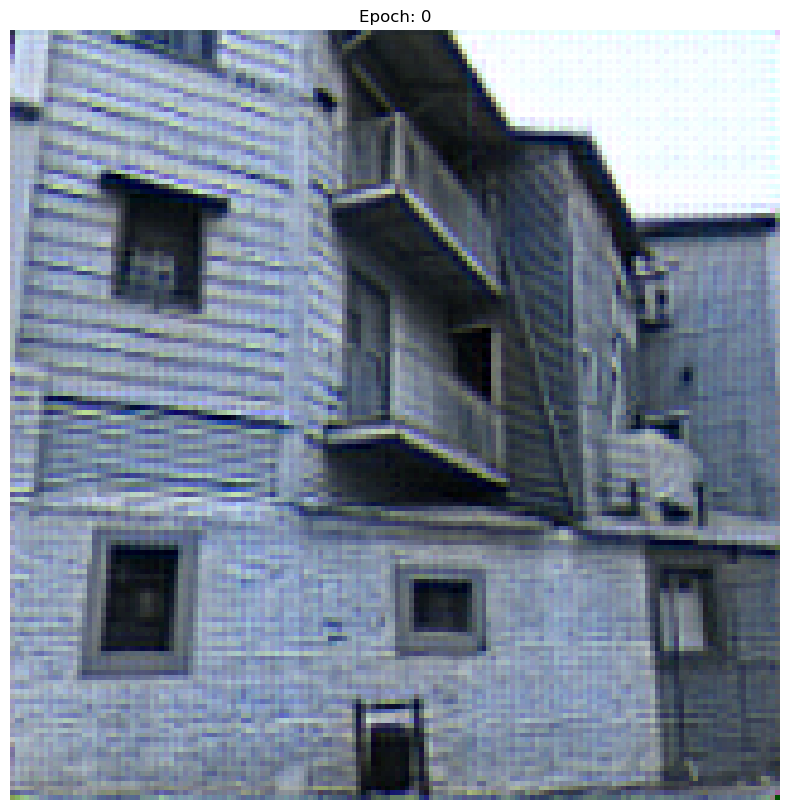

550/550 [==============================] - 32s 49ms/step - loss: 0.0757 - acc: 0.4069
Epoch 2/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0523 - acc: 0.45


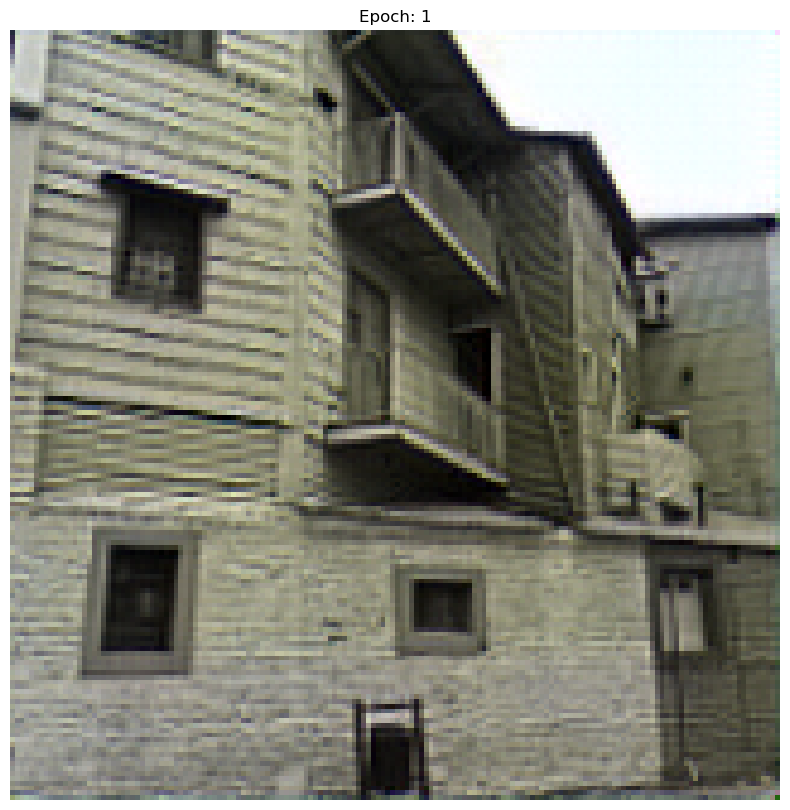

550/550 [==============================] - 26s 47ms/step - loss: 0.0523 - acc: 0.4595
Epoch 3/50
1/1 [==============================] - 0s 22ms/step- loss: 0.0490 - acc: 0.47


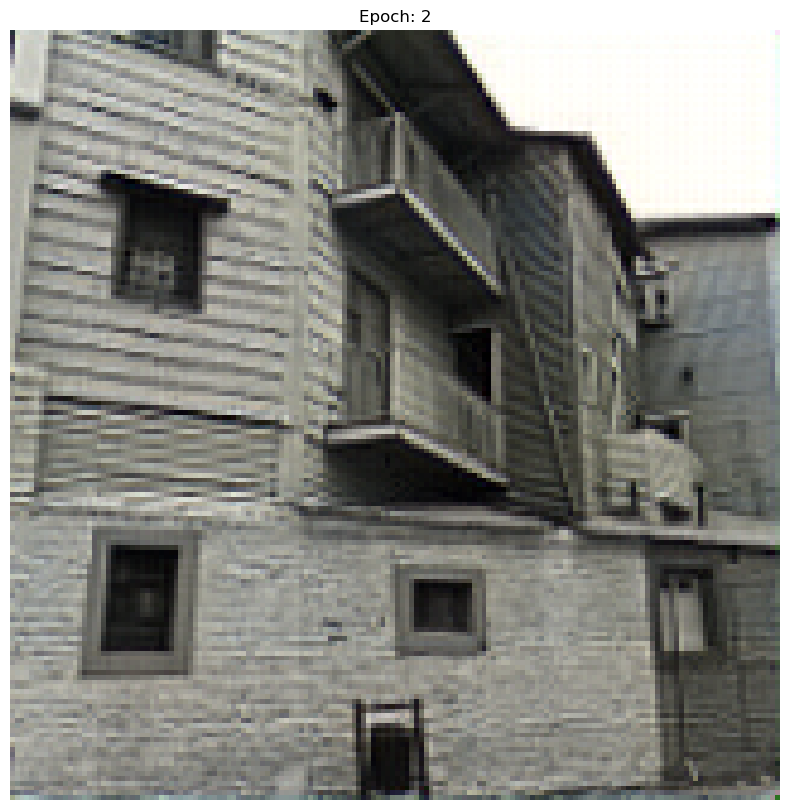

550/550 [==============================] - 26s 47ms/step - loss: 0.0490 - acc: 0.4769
Epoch 4/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0479 - acc: 0.48


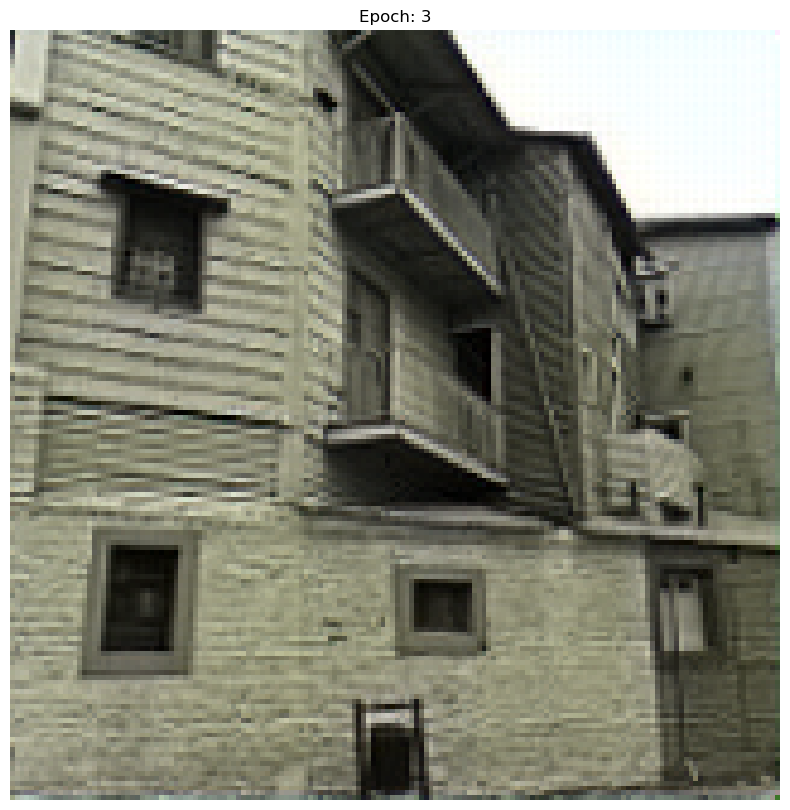

550/550 [==============================] - 26s 47ms/step - loss: 0.0479 - acc: 0.4846
Epoch 5/50
1/1 [==============================] - 0s 36ms/step- loss: 0.0470 - acc: 0.49


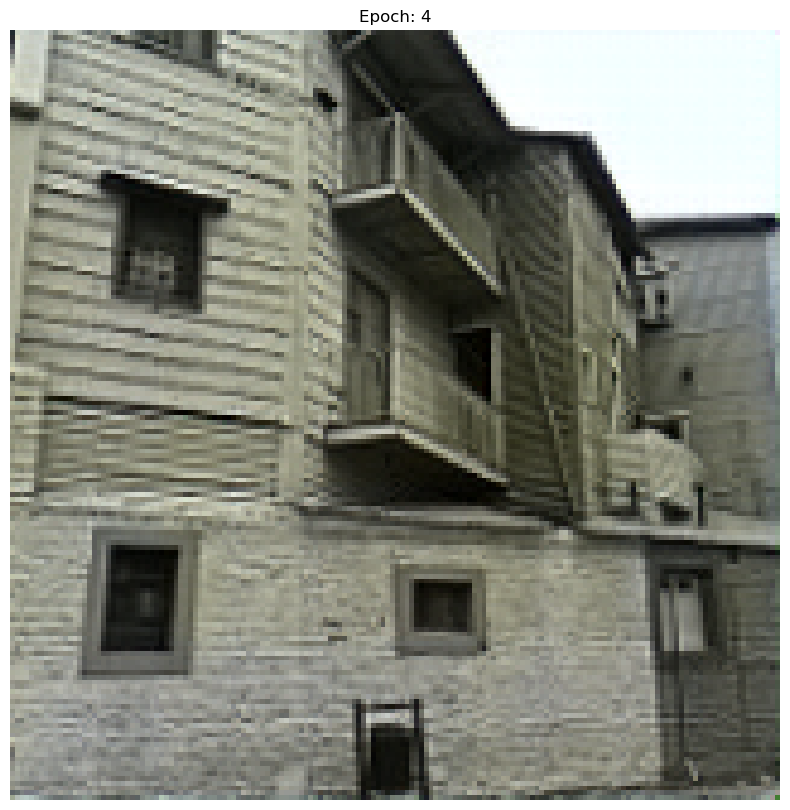

550/550 [==============================] - 28s 52ms/step - loss: 0.0470 - acc: 0.4952
Epoch 6/50
1/1 [==============================] - 0s 18ms/step- loss: 0.0464 - acc: 0.50


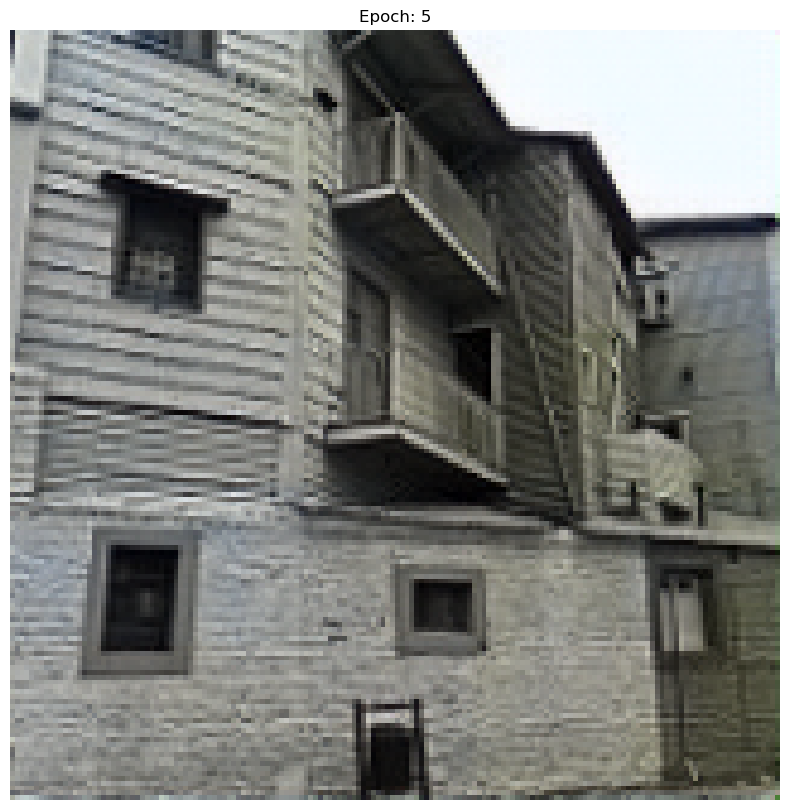

550/550 [==============================] - 25s 46ms/step - loss: 0.0464 - acc: 0.5051
Epoch 7/50
1/1 [==============================] - 0s 17ms/step- loss: 0.0461 - acc: 0.51


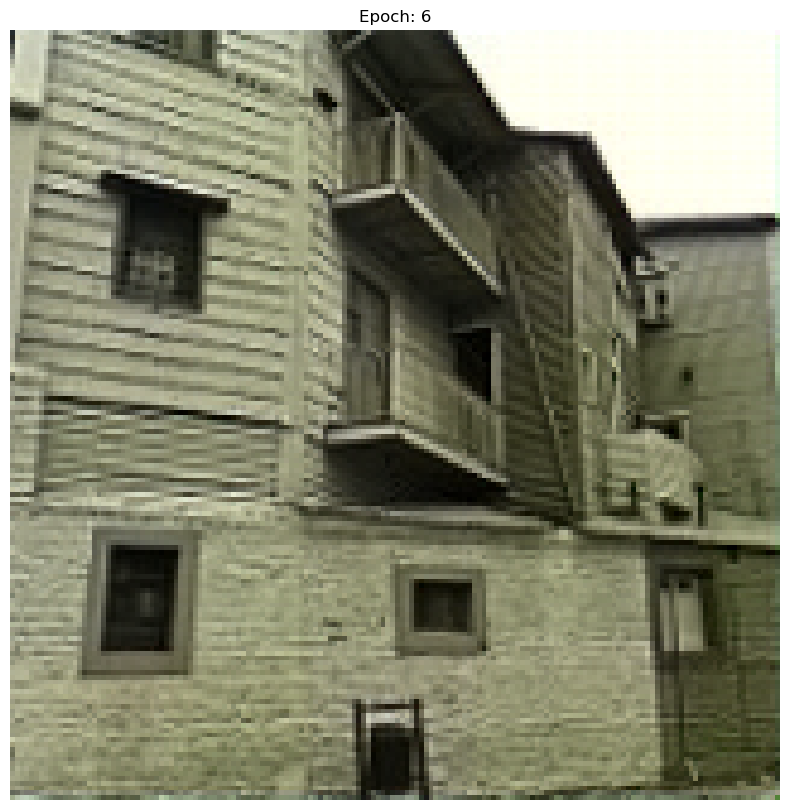

550/550 [==============================] - 26s 47ms/step - loss: 0.0461 - acc: 0.5109
Epoch 8/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0454 - acc: 0.51


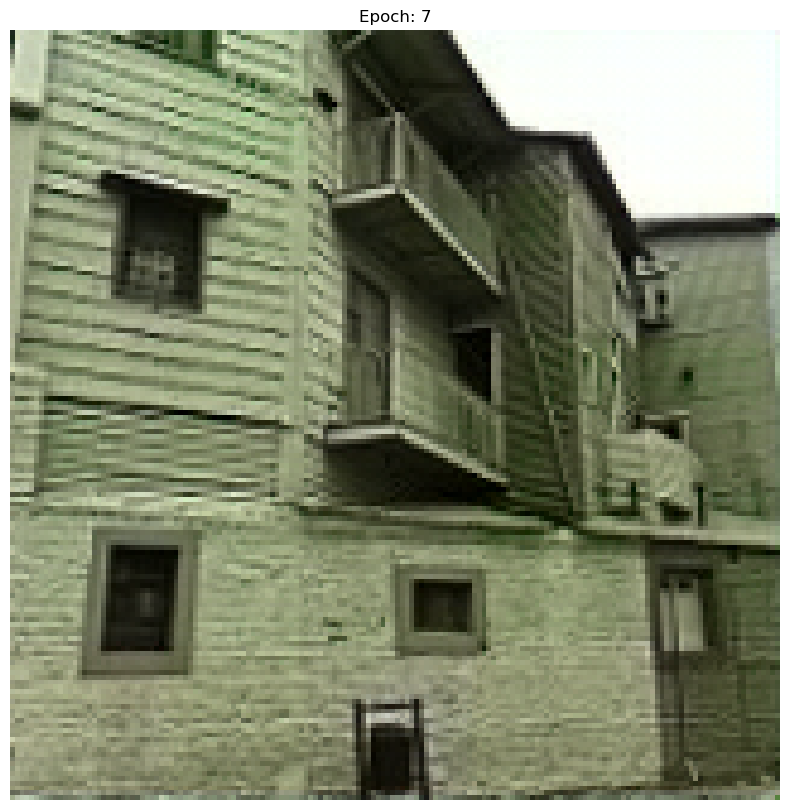

550/550 [==============================] - 25s 46ms/step - loss: 0.0454 - acc: 0.5193
Epoch 9/50
1/1 [==============================] - 0s 18ms/step- loss: 0.0450 - acc: 0.52


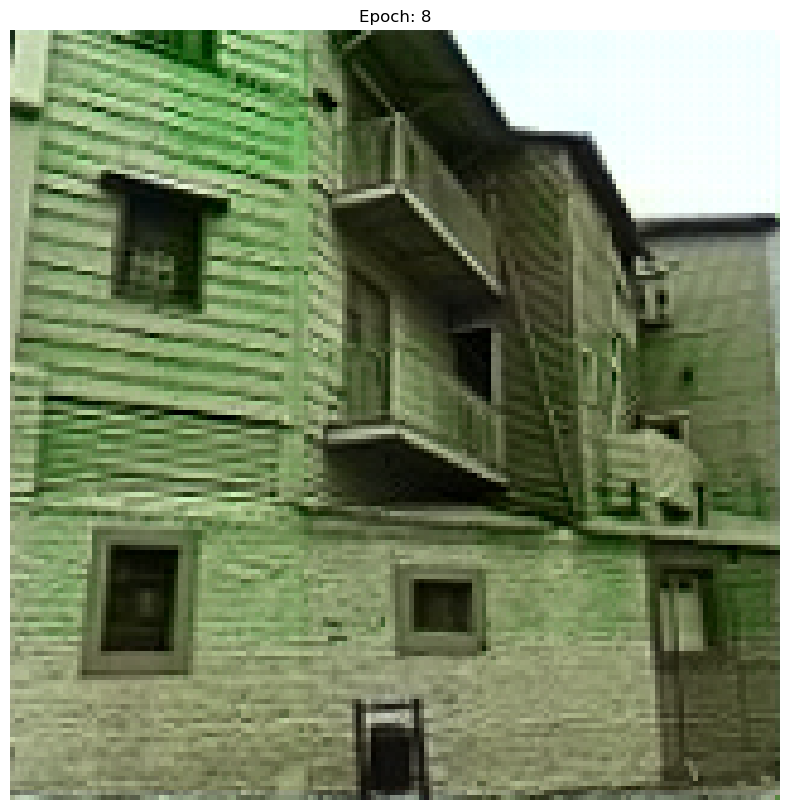

550/550 [==============================] - 26s 48ms/step - loss: 0.0450 - acc: 0.5281
Epoch 10/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0447 - acc: 0.53


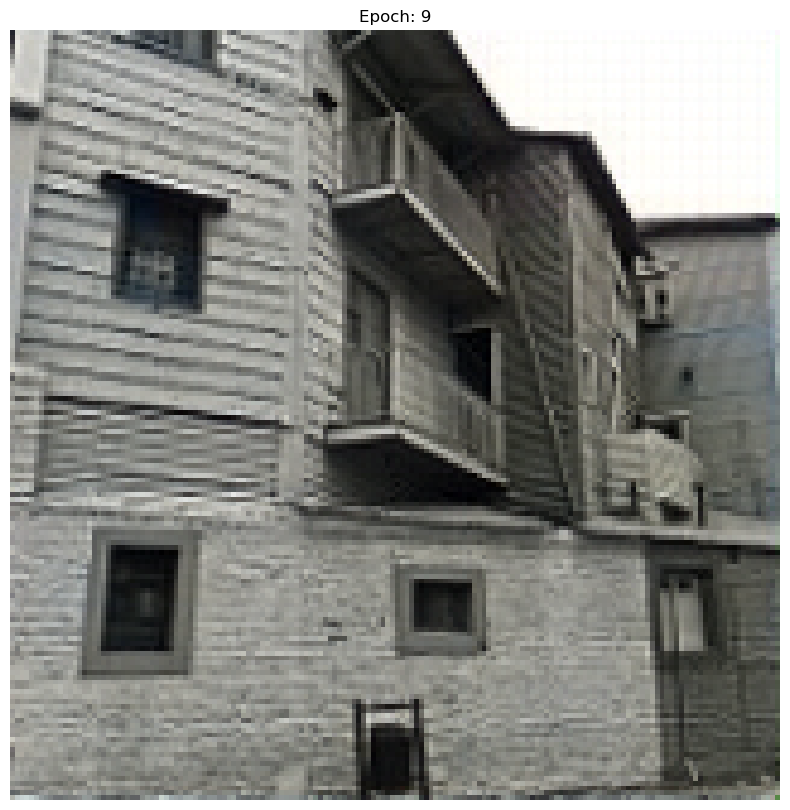

550/550 [==============================] - 26s 47ms/step - loss: 0.0447 - acc: 0.5373
Epoch 11/50
1/1 [==============================] - 0s 16ms/step- loss: 0.0444 - acc: 0.54


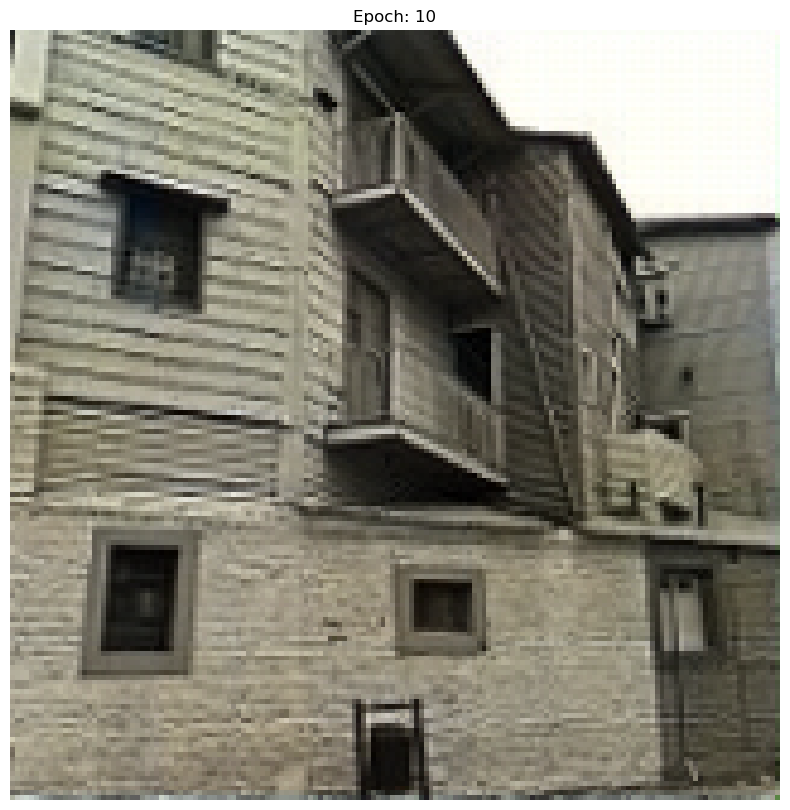

550/550 [==============================] - 26s 47ms/step - loss: 0.0444 - acc: 0.5419
Epoch 12/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0438 - acc: 0.55


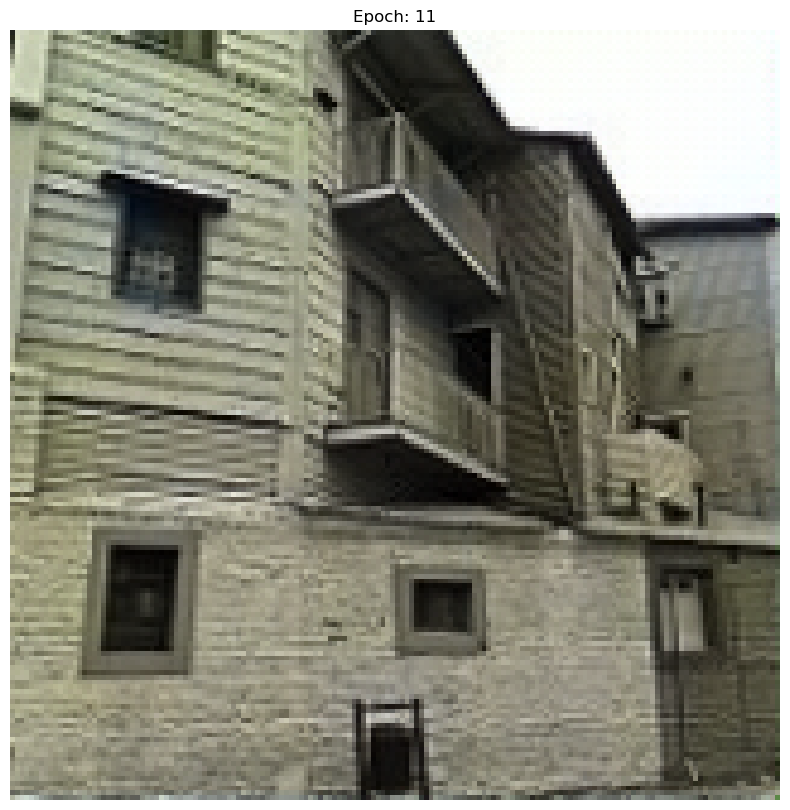

550/550 [==============================] - 26s 48ms/step - loss: 0.0438 - acc: 0.5533
Epoch 13/50
1/1 [==============================] - 0s 38ms/step- loss: 0.0436 - acc: 0.55


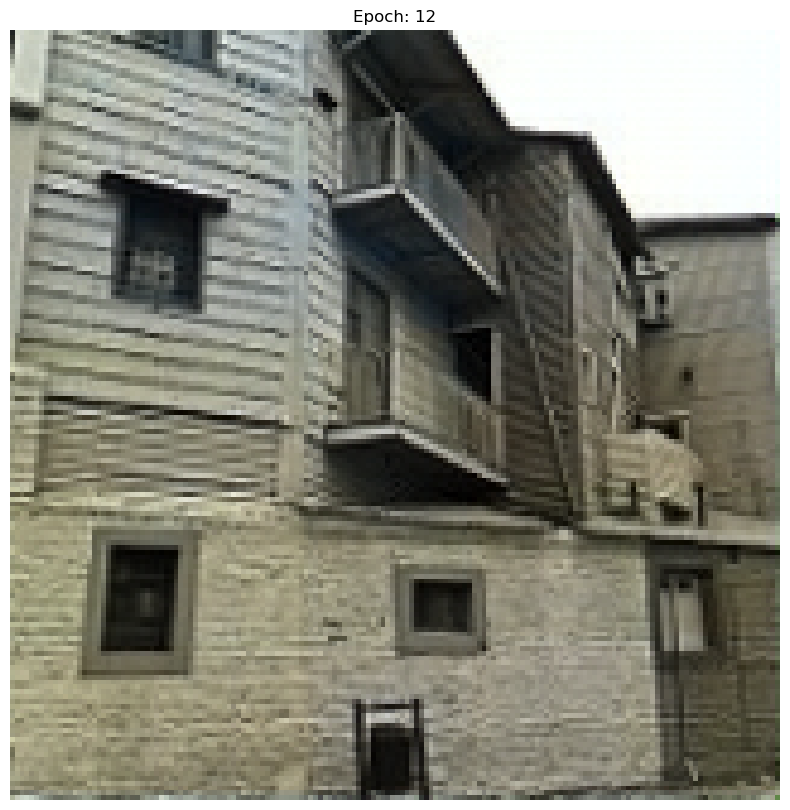

550/550 [==============================] - 26s 47ms/step - loss: 0.0436 - acc: 0.5558
Epoch 14/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0428 - acc: 0.57


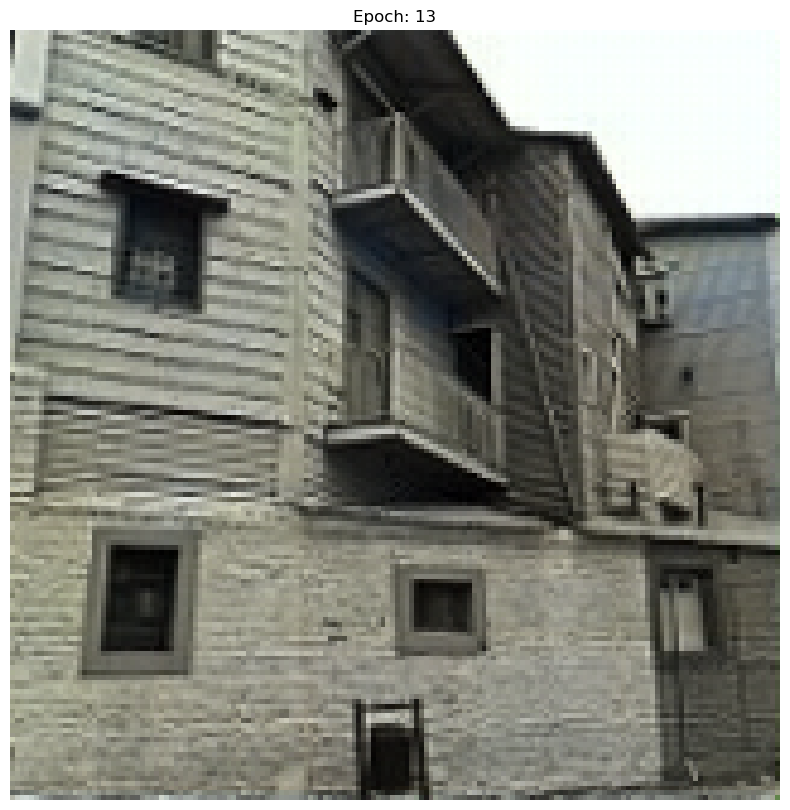

550/550 [==============================] - 26s 47ms/step - loss: 0.0428 - acc: 0.5702
Epoch 15/50
1/1 [==============================] - 0s 16ms/step- loss: 0.0424 - acc: 0.57


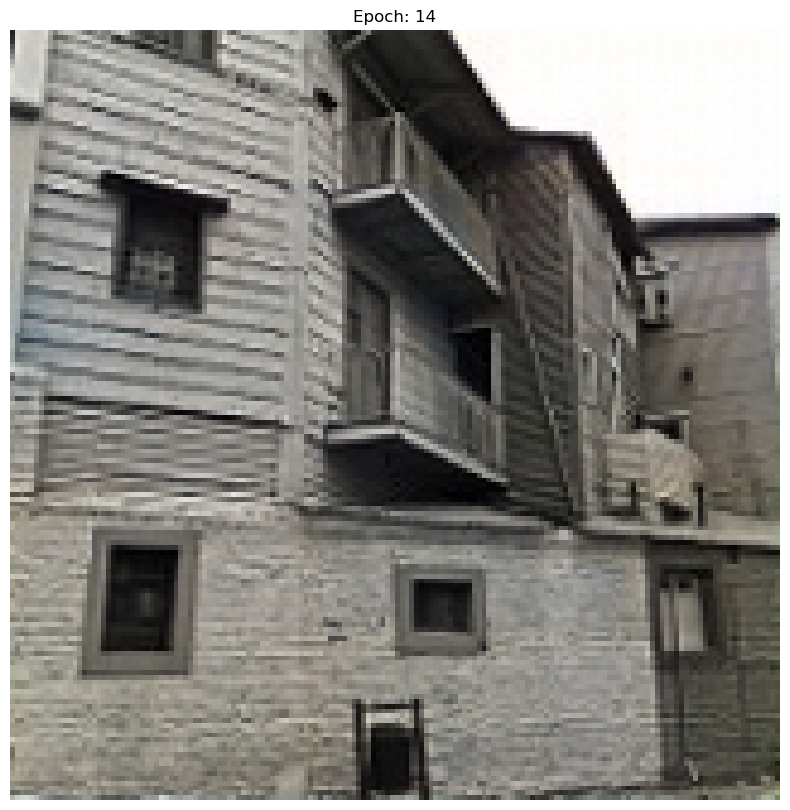

550/550 [==============================] - 26s 47ms/step - loss: 0.0424 - acc: 0.5749
Epoch 16/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0419 - acc: 0.58


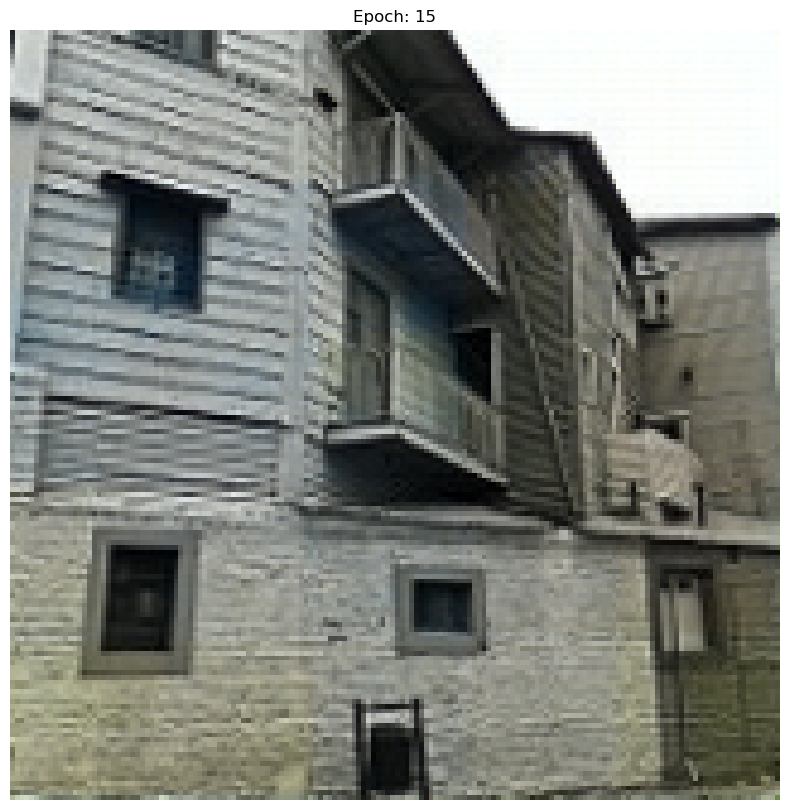

550/550 [==============================] - 27s 50ms/step - loss: 0.0419 - acc: 0.5816
Epoch 17/50
1/1 [==============================] - 0s 13ms/step- loss: 0.0412 - acc: 0.59


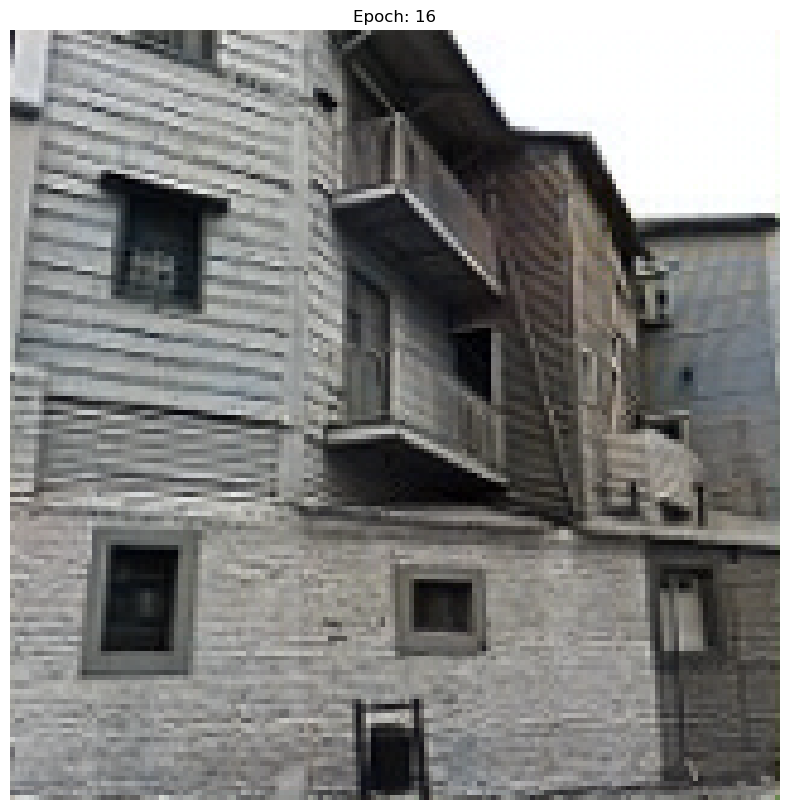

550/550 [==============================] - 26s 48ms/step - loss: 0.0412 - acc: 0.5924
Epoch 18/50
1/1 [==============================] - 0s 24ms/step- loss: 0.0406 - acc: 0.60


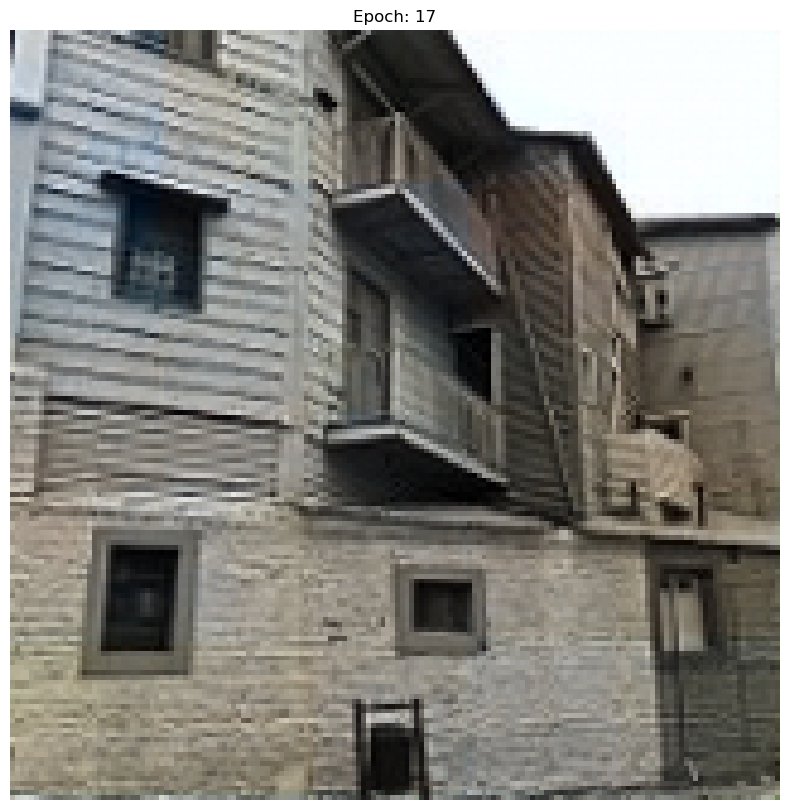

550/550 [==============================] - 27s 48ms/step - loss: 0.0406 - acc: 0.6011
Epoch 19/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0398 - acc: 0.60


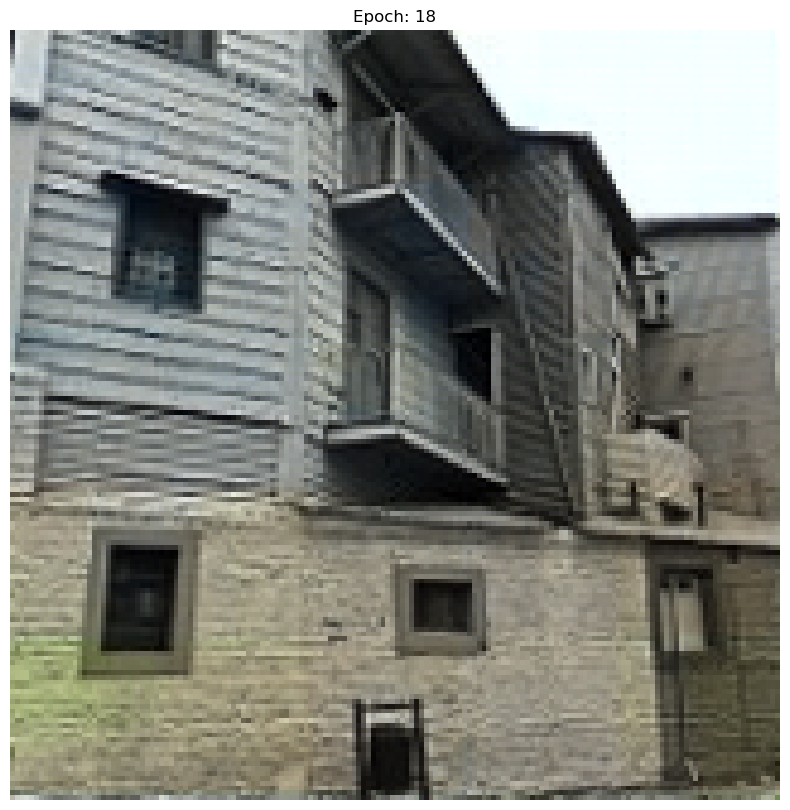

550/550 [==============================] - 26s 47ms/step - loss: 0.0398 - acc: 0.6098
Epoch 20/50
1/1 [==============================] - 0s 21ms/step- loss: 0.0391 - acc: 0.61


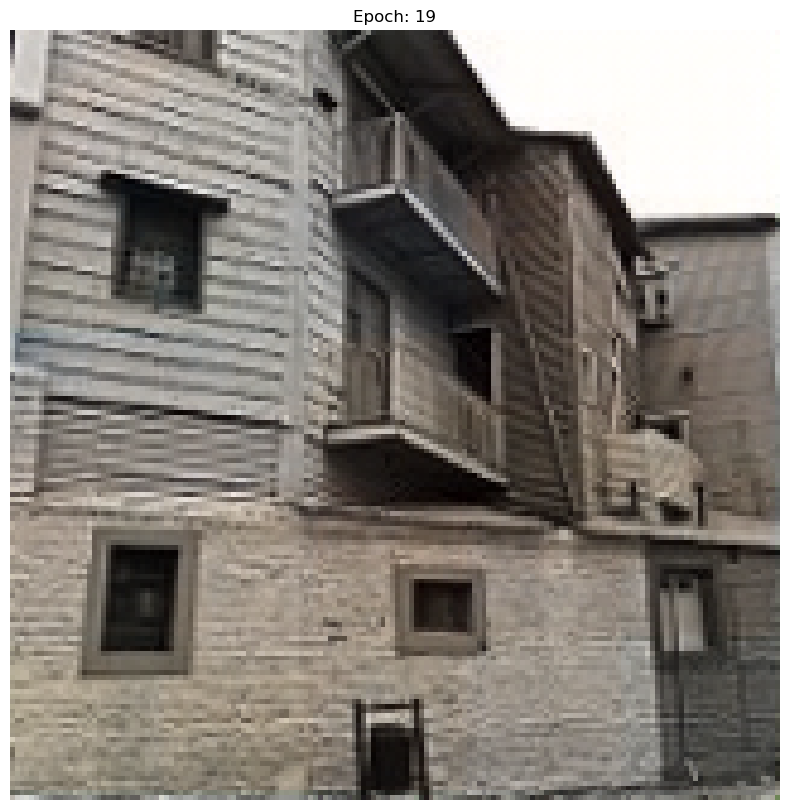

550/550 [==============================] - 26s 48ms/step - loss: 0.0391 - acc: 0.6199
Epoch 21/50
1/1 [==============================] - 0s 21ms/step- loss: 0.0383 - acc: 0.62


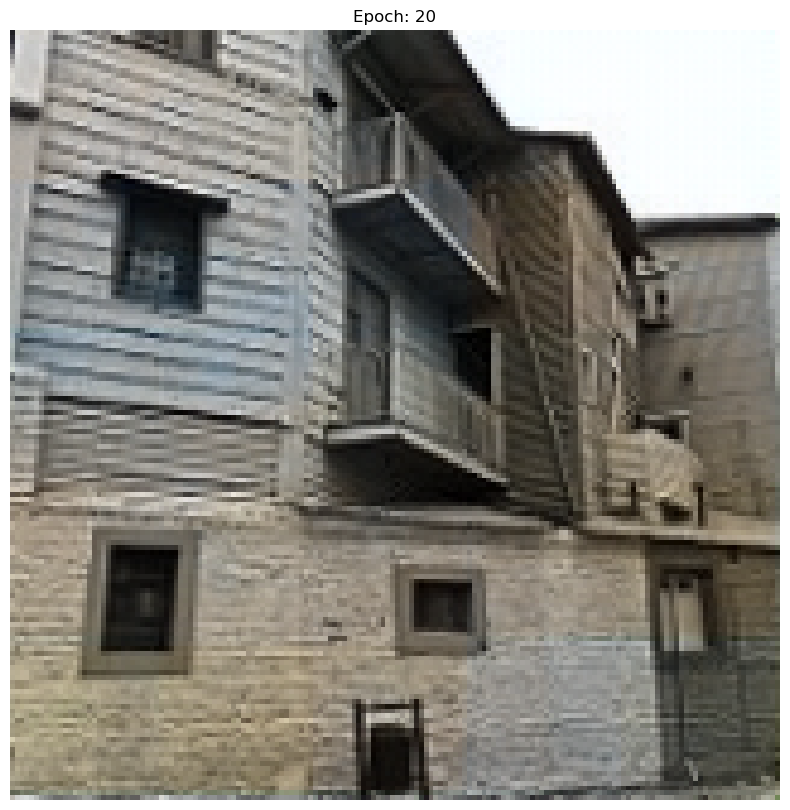

550/550 [==============================] - 26s 47ms/step - loss: 0.0383 - acc: 0.6272
Epoch 22/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0376 - acc: 0.63


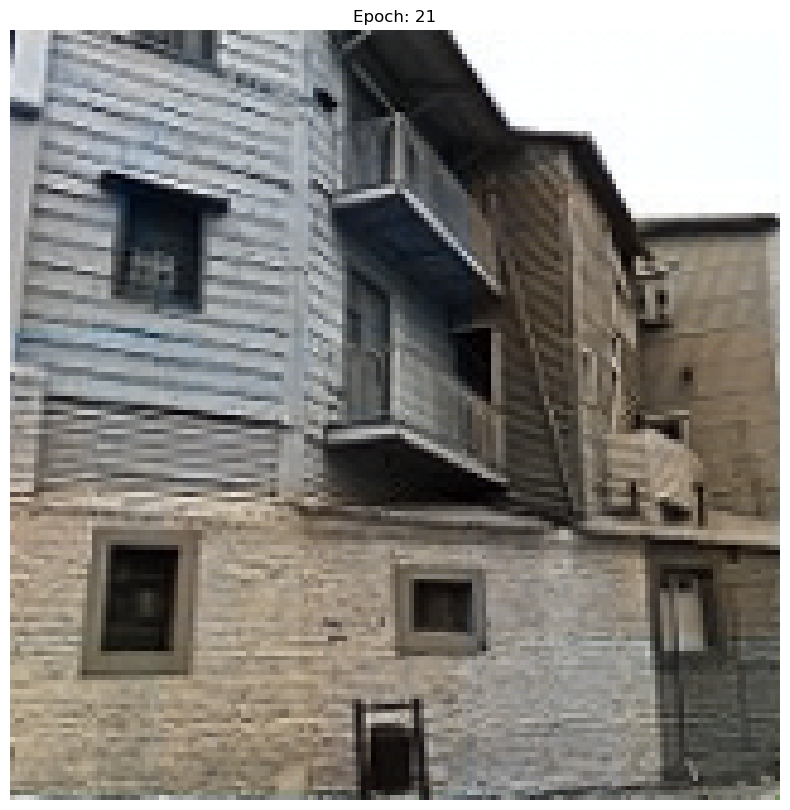

550/550 [==============================] - 26s 48ms/step - loss: 0.0376 - acc: 0.6356
Epoch 23/50
1/1 [==============================] - 0s 20ms/step- loss: 0.0369 - acc: 0.64


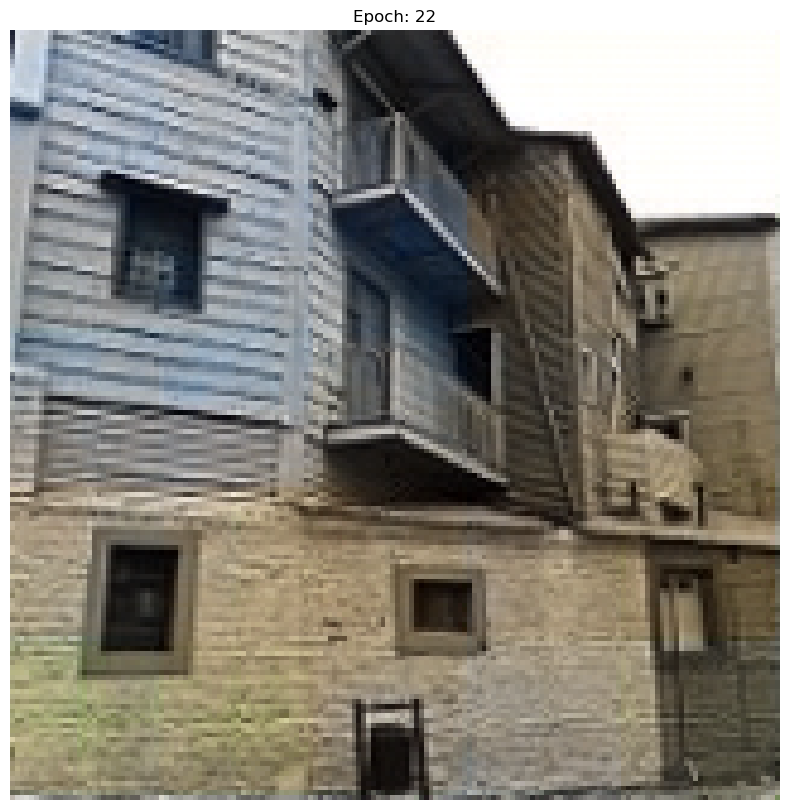

550/550 [==============================] - 27s 48ms/step - loss: 0.0369 - acc: 0.6425
Epoch 24/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0363 - acc: 0.64


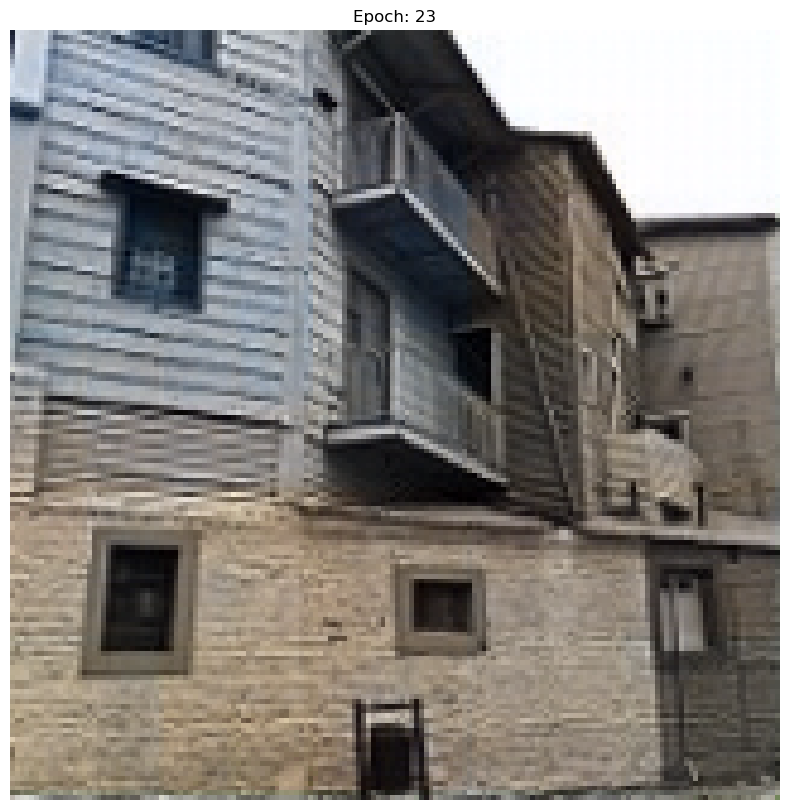

550/550 [==============================] - 25s 46ms/step - loss: 0.0363 - acc: 0.6480
Epoch 25/50
1/1 [==============================] - 0s 21ms/step- loss: 0.0355 - acc: 0.65


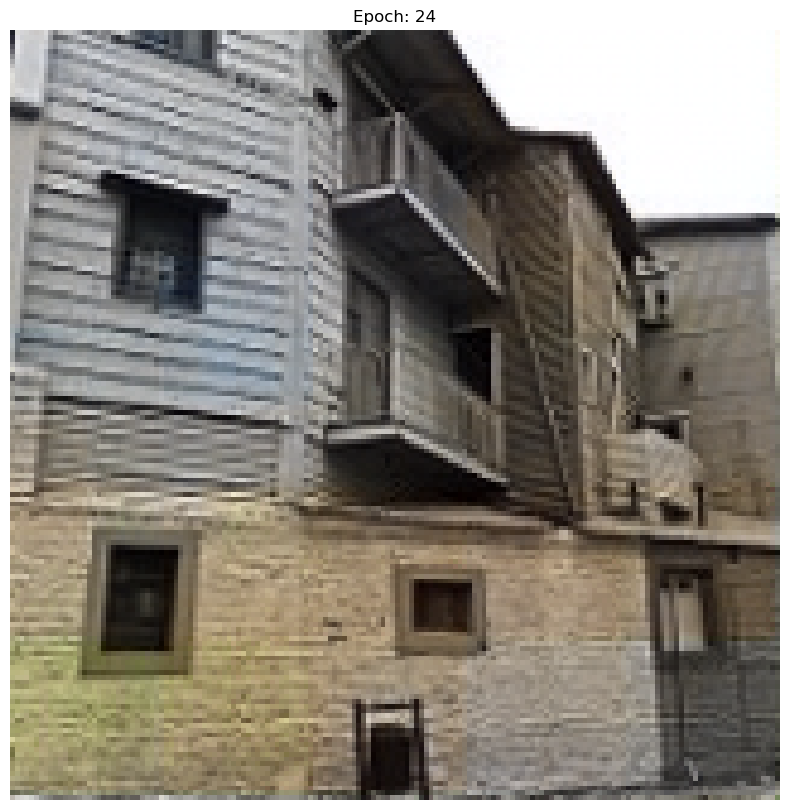

550/550 [==============================] - 27s 48ms/step - loss: 0.0355 - acc: 0.6556
Epoch 26/50
1/1 [==============================] - 0s 18ms/step- loss: 0.0348 - acc: 0.66


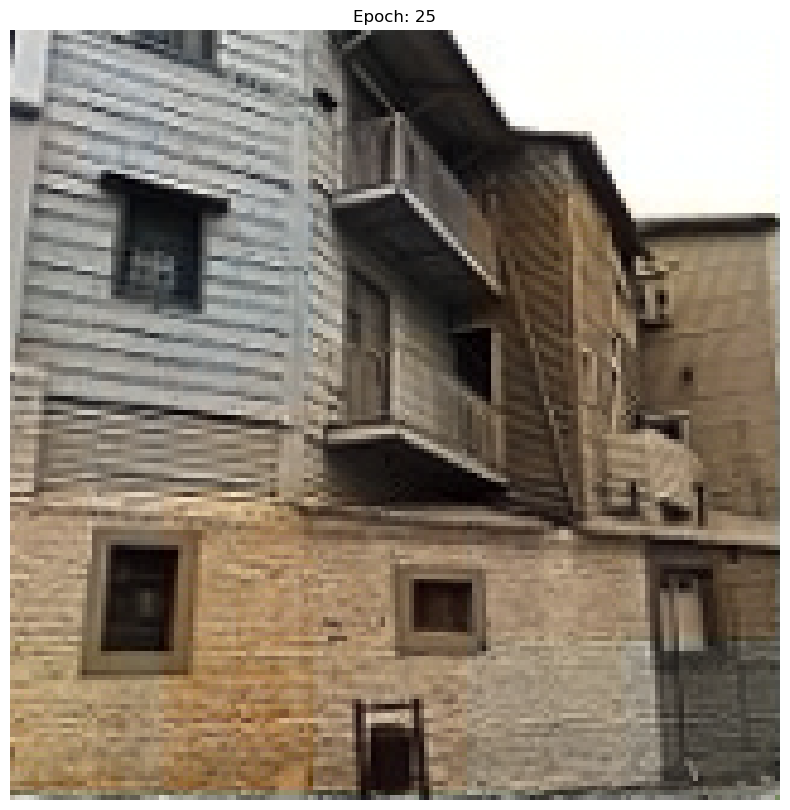

550/550 [==============================] - 25s 46ms/step - loss: 0.0348 - acc: 0.6639
Epoch 27/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0342 - acc: 0.66


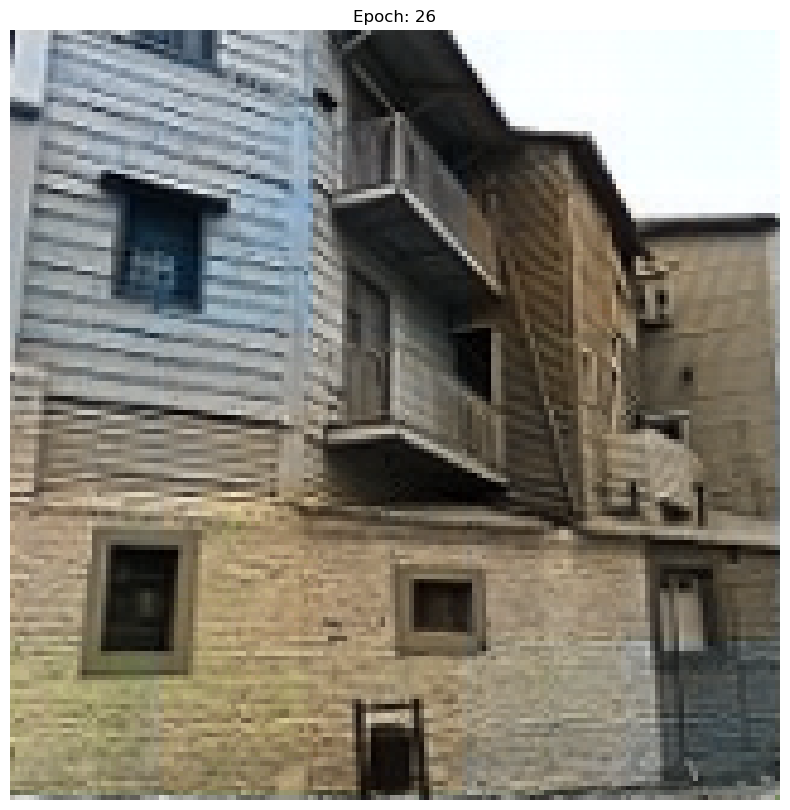

550/550 [==============================] - 25s 46ms/step - loss: 0.0342 - acc: 0.6685
Epoch 28/50
1/1 [==============================] - 0s 18ms/step- loss: 0.0336 - acc: 0.67


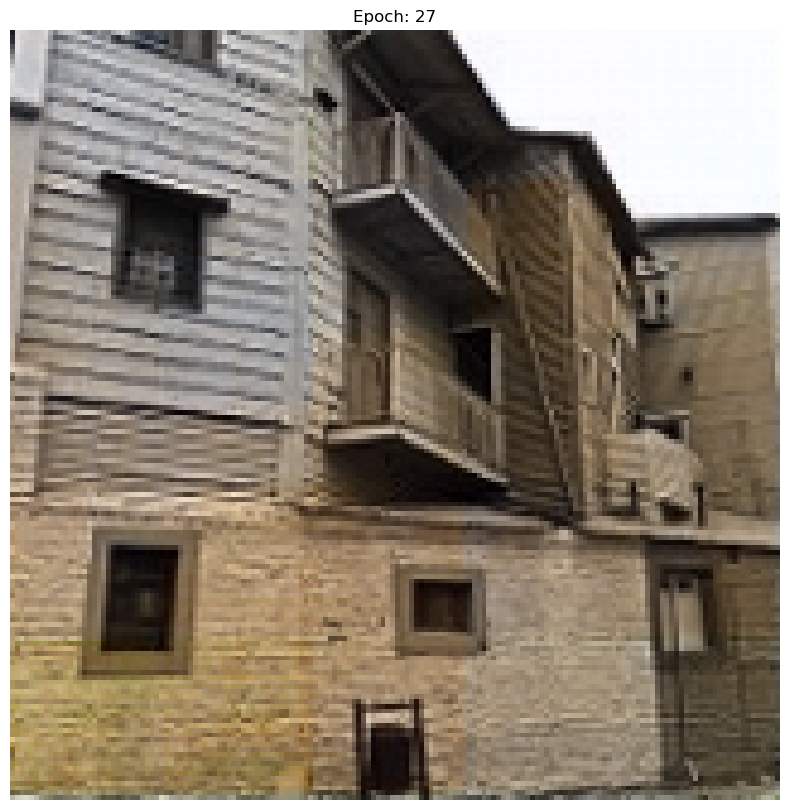

550/550 [==============================] - 25s 46ms/step - loss: 0.0336 - acc: 0.6740
Epoch 29/50
1/1 [==============================] - 0s 23ms/step- loss: 0.0329 - acc: 0.68


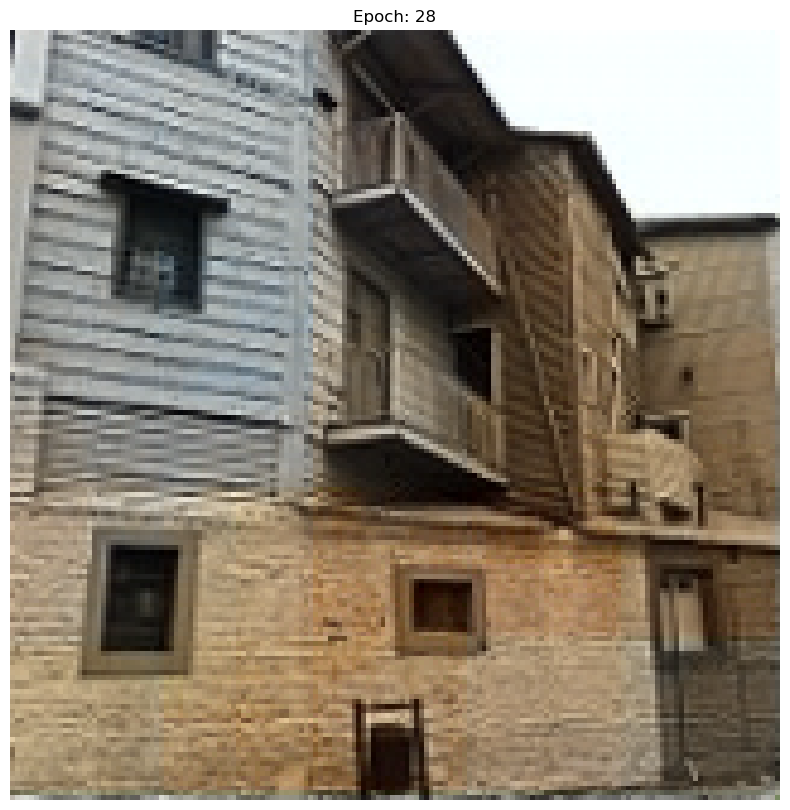

550/550 [==============================] - 25s 46ms/step - loss: 0.0329 - acc: 0.6819
Epoch 30/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0322 - acc: 0.68


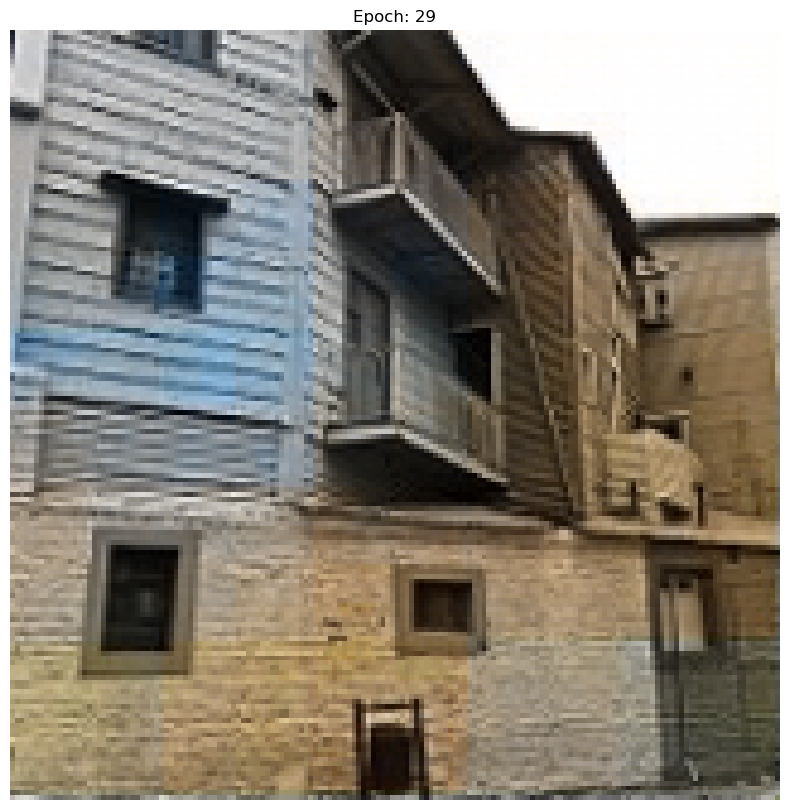

550/550 [==============================] - 26s 48ms/step - loss: 0.0322 - acc: 0.6870
Epoch 31/50
1/1 [==============================] - 0s 18ms/step- loss: 0.0318 - acc: 0.69


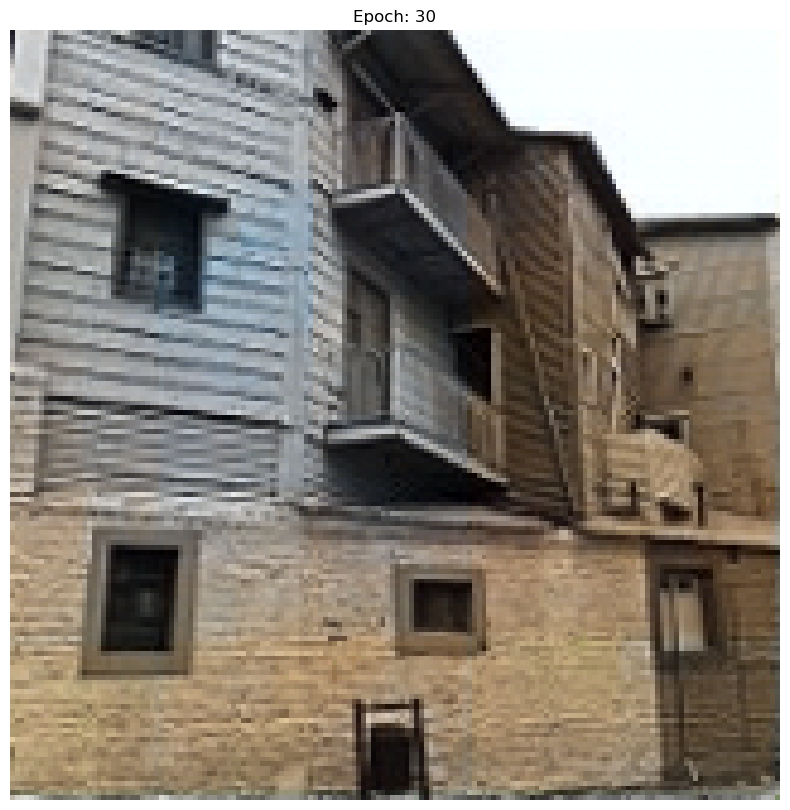

550/550 [==============================] - 26s 47ms/step - loss: 0.0318 - acc: 0.6902
Epoch 32/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0311 - acc: 0.69


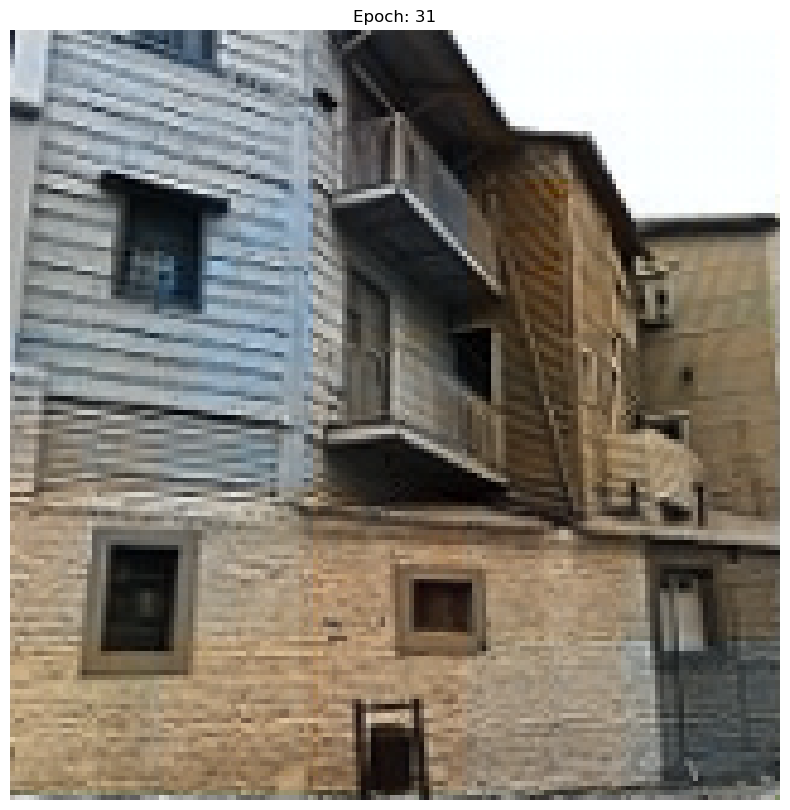

550/550 [==============================] - 26s 47ms/step - loss: 0.0311 - acc: 0.6981
Epoch 33/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0306 - acc: 0.70


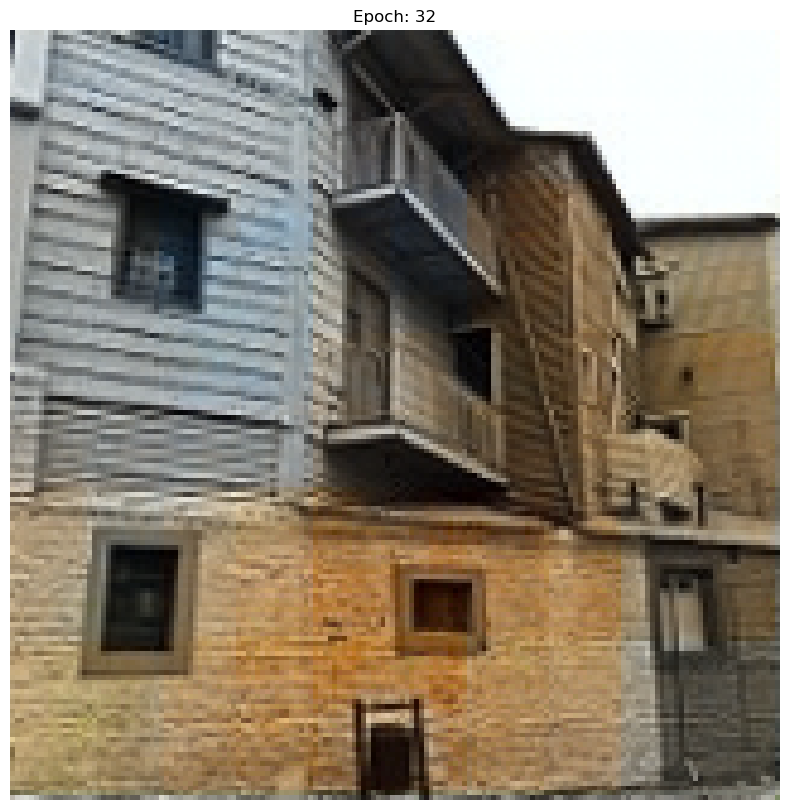

550/550 [==============================] - 26s 47ms/step - loss: 0.0306 - acc: 0.7027
Epoch 34/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0302 - acc: 0.70


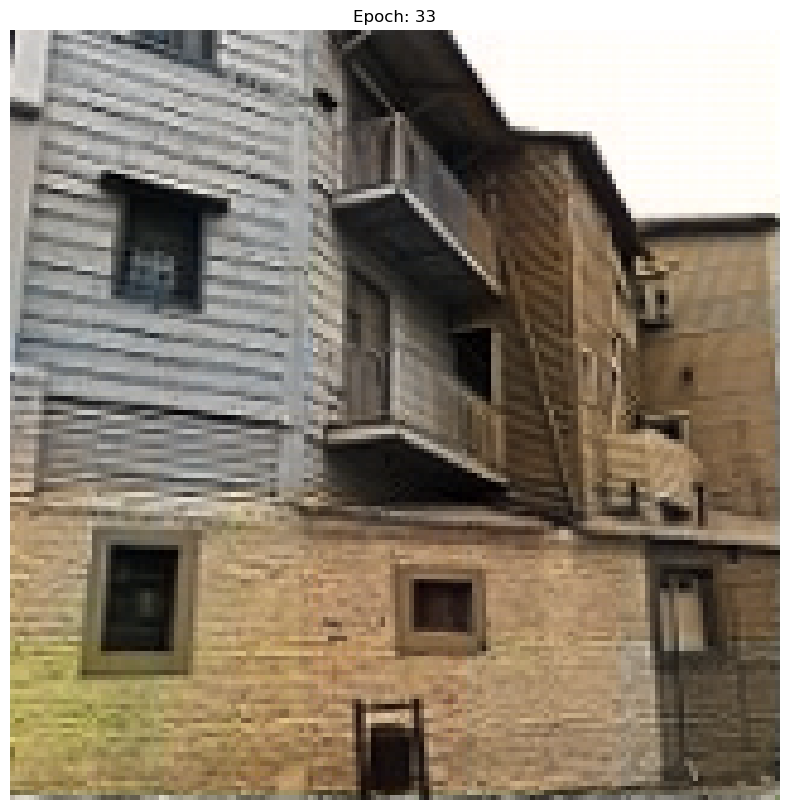

550/550 [==============================] - 26s 47ms/step - loss: 0.0302 - acc: 0.7052
Epoch 35/50
1/1 [==============================] - 0s 26ms/step- loss: 0.0295 - acc: 0.71


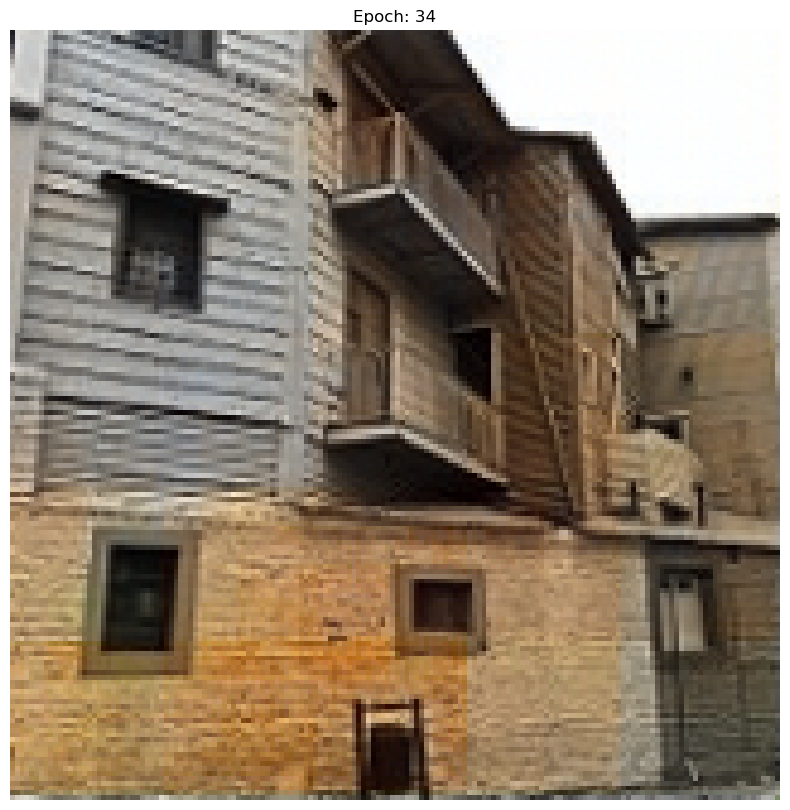

550/550 [==============================] - 26s 47ms/step - loss: 0.0295 - acc: 0.7110
Epoch 36/50
1/1 [==============================] - 0s 22ms/step- loss: 0.0292 - acc: 0.71


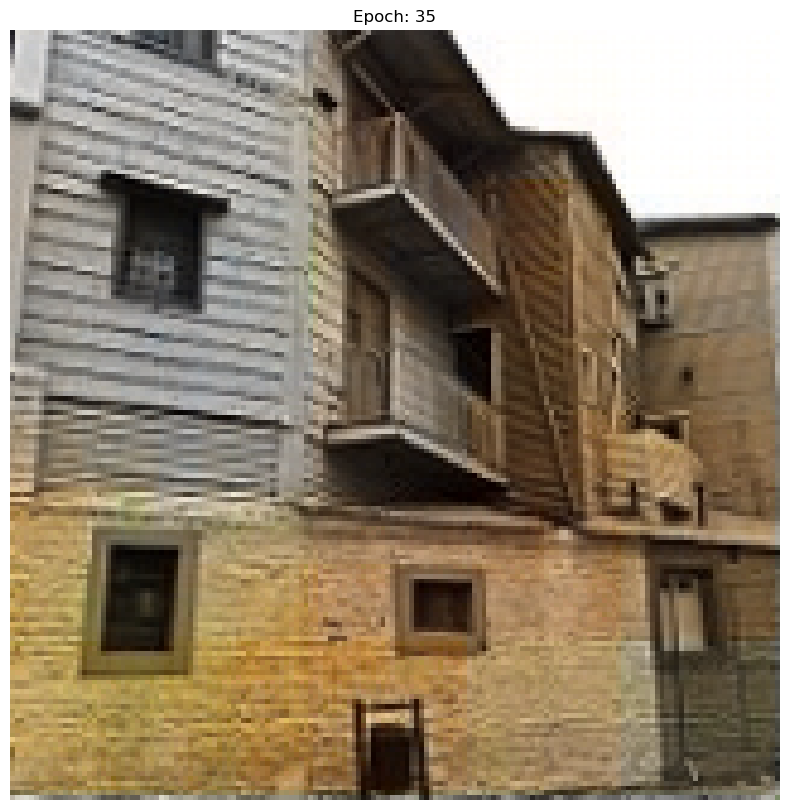

550/550 [==============================] - 26s 47ms/step - loss: 0.0292 - acc: 0.7140
Epoch 37/50
1/1 [==============================] - 0s 17ms/step- loss: 0.0288 - acc: 0.71


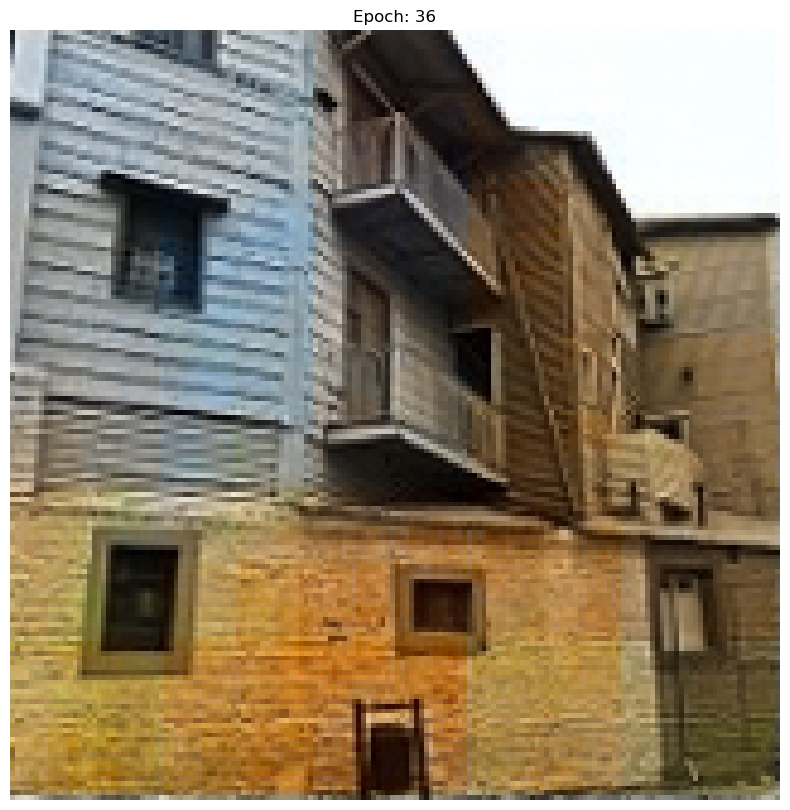

550/550 [==============================] - 26s 47ms/step - loss: 0.0288 - acc: 0.7186
Epoch 38/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0284 - acc: 0.72


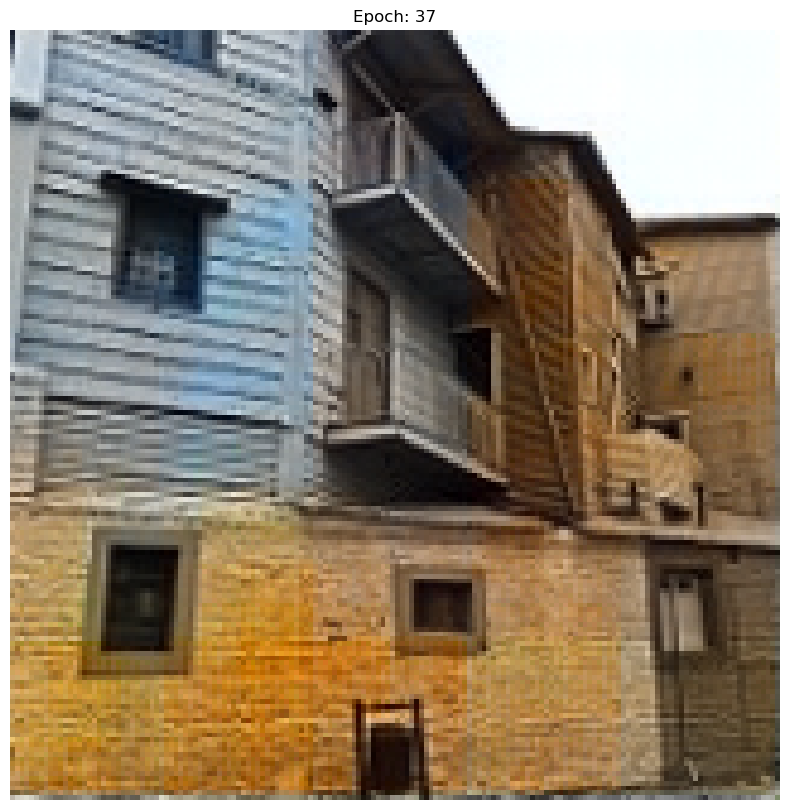

550/550 [==============================] - 26s 47ms/step - loss: 0.0284 - acc: 0.7218
Epoch 39/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0279 - acc: 0.72


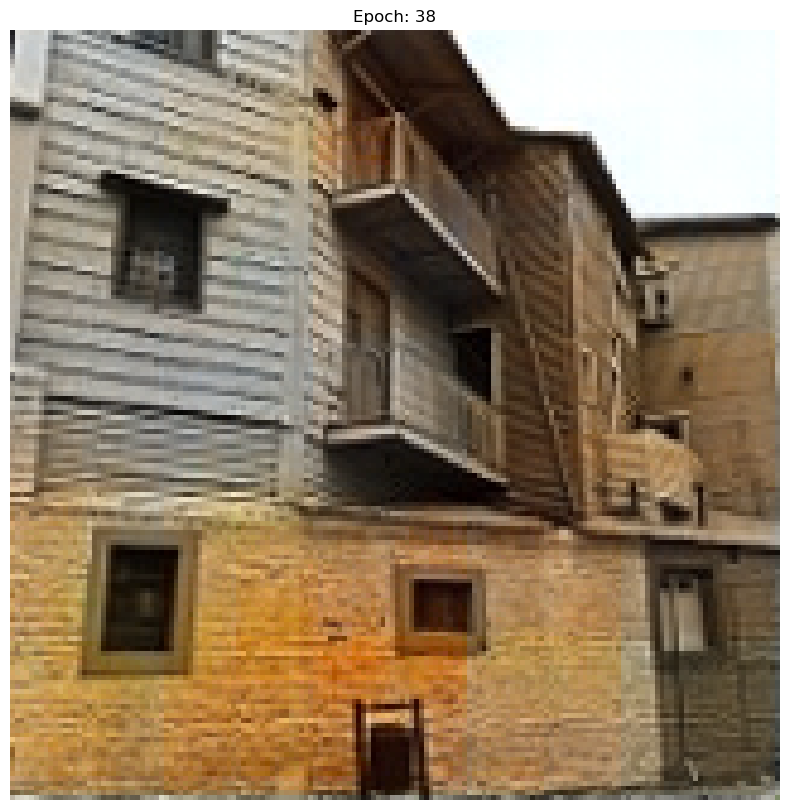

550/550 [==============================] - 26s 46ms/step - loss: 0.0279 - acc: 0.7270
Epoch 40/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0274 - acc: 0.72


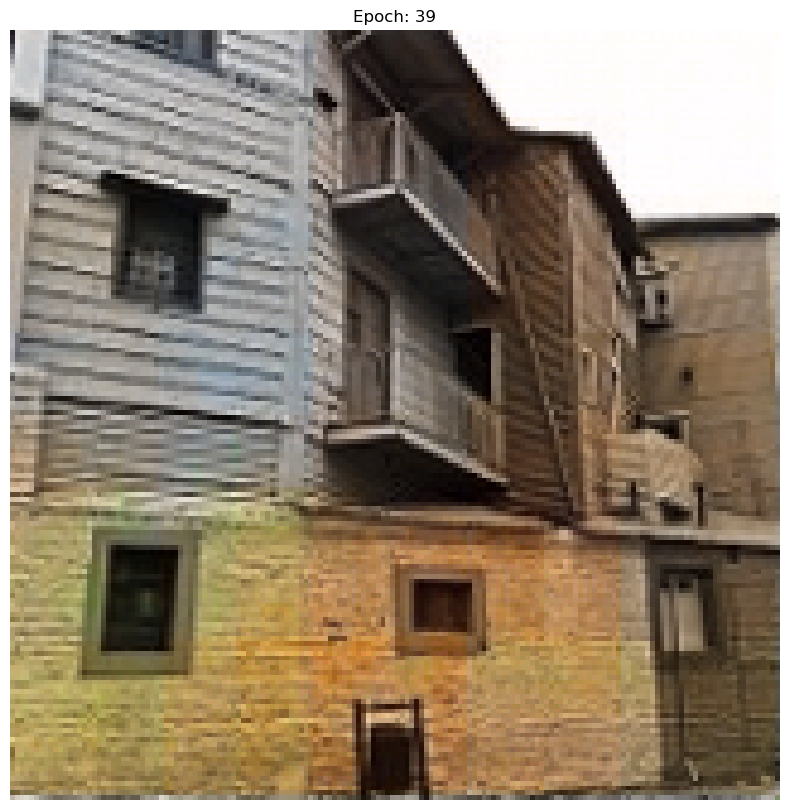

550/550 [==============================] - 26s 47ms/step - loss: 0.0274 - acc: 0.7292
Epoch 41/50
1/1 [==============================] - 0s 52ms/step- loss: 0.0271 - acc: 0.73


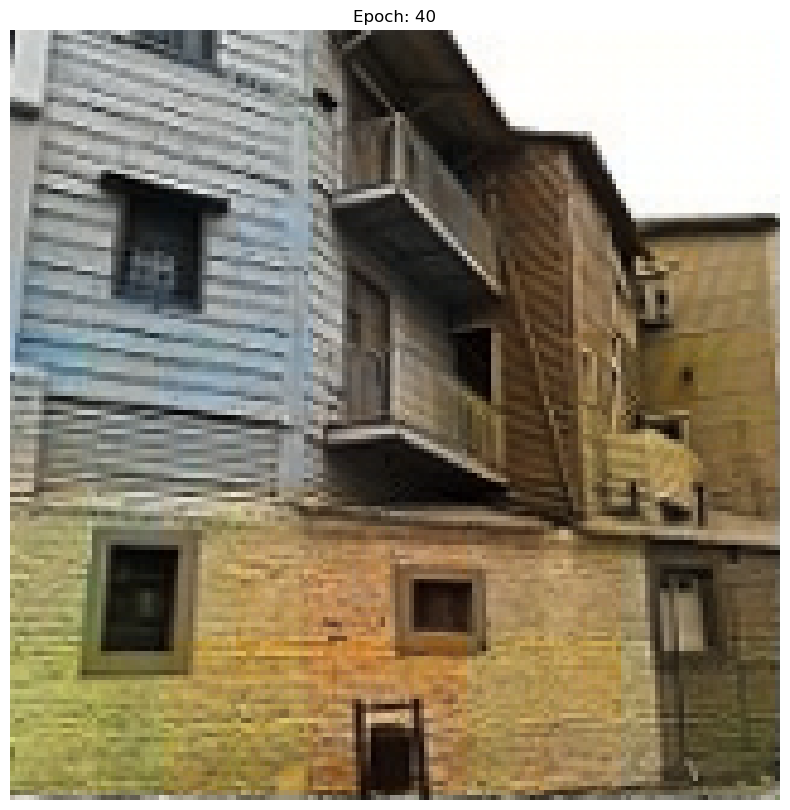

550/550 [==============================] - 26s 47ms/step - loss: 0.0271 - acc: 0.7333
Epoch 42/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0269 - acc: 0.73


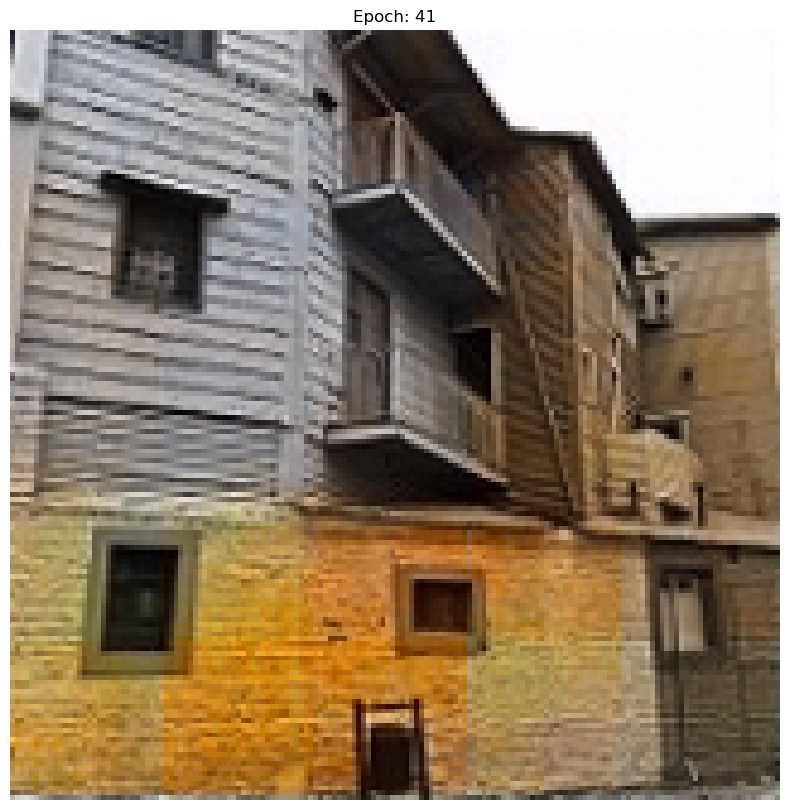

550/550 [==============================] - 26s 47ms/step - loss: 0.0269 - acc: 0.7342
Epoch 43/50
1/1 [==============================] - 0s 21ms/step- loss: 0.0265 - acc: 0.73


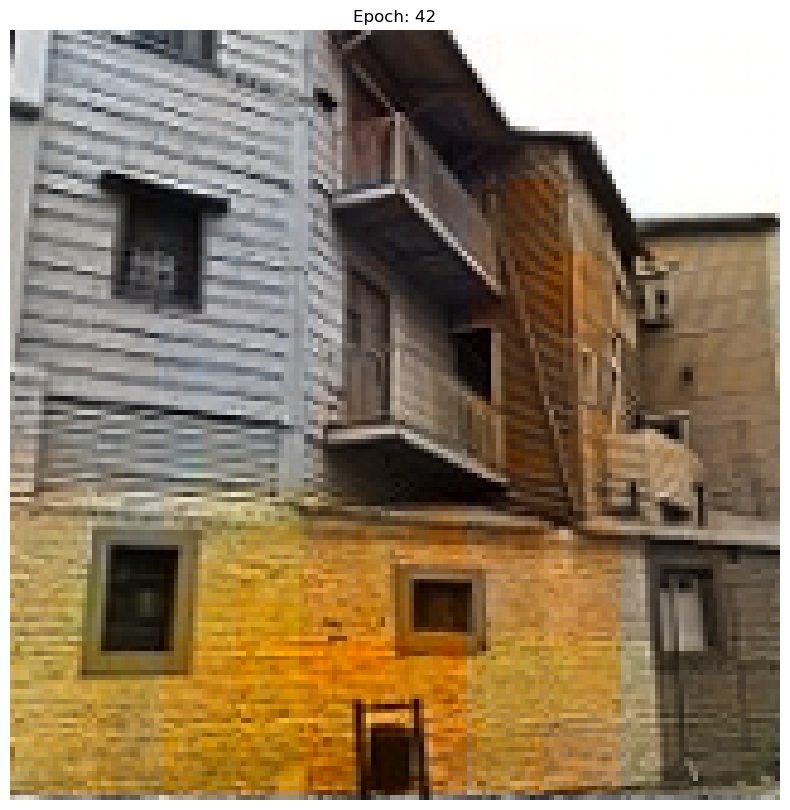

550/550 [==============================] - 26s 47ms/step - loss: 0.0265 - acc: 0.7360
Epoch 44/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0258 - acc: 0.74


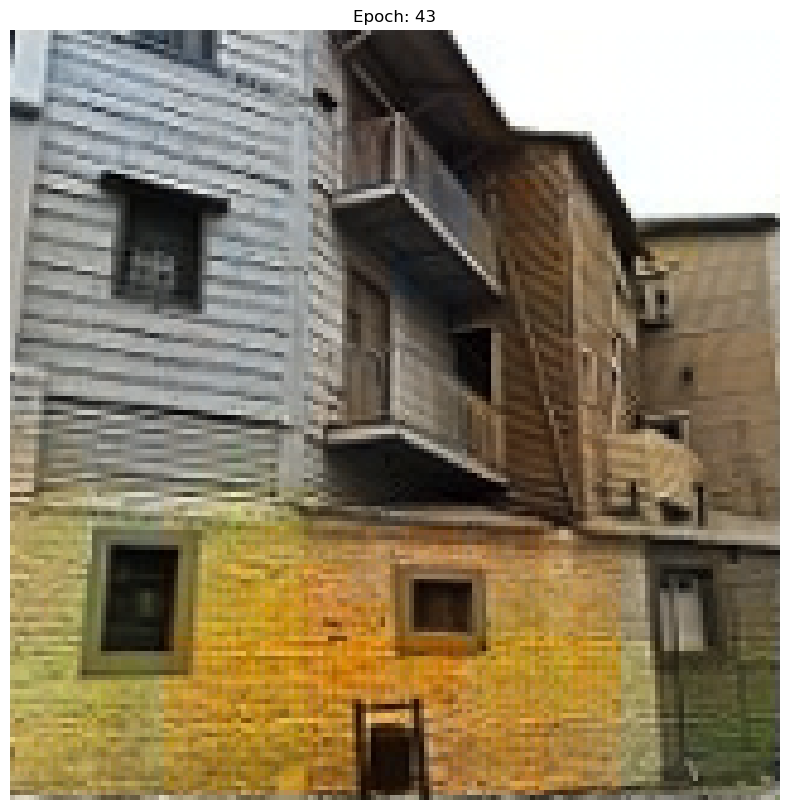

550/550 [==============================] - 25s 46ms/step - loss: 0.0257 - acc: 0.7451
Epoch 45/50
1/1 [==============================] - 0s 14ms/step- loss: 0.0257 - acc: 0.74


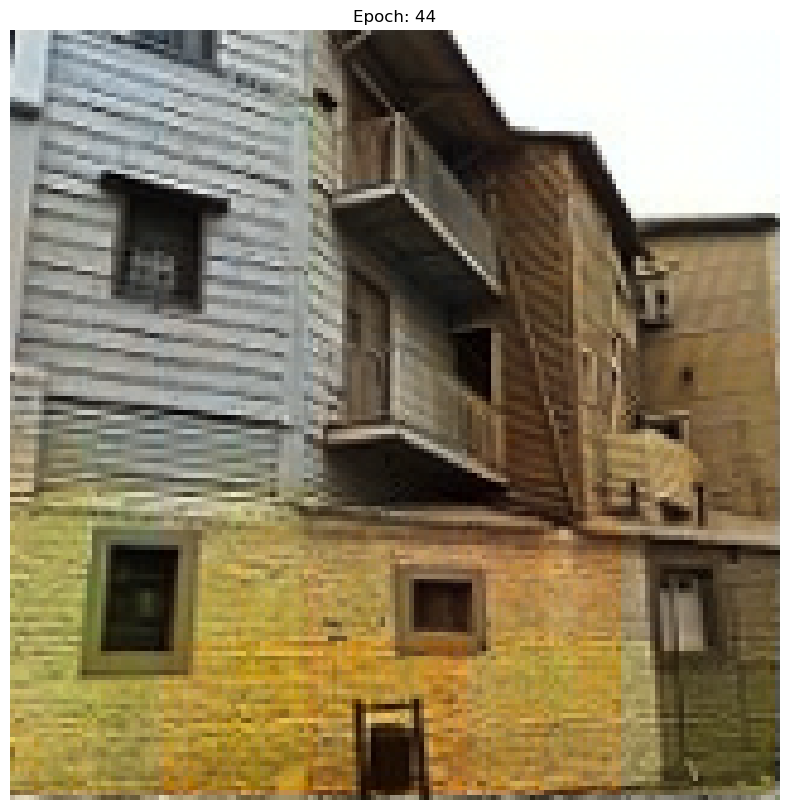

550/550 [==============================] - 25s 46ms/step - loss: 0.0257 - acc: 0.7449
Epoch 46/50
1/1 [==============================] - 0s 19ms/step- loss: 0.0255 - acc: 0.74


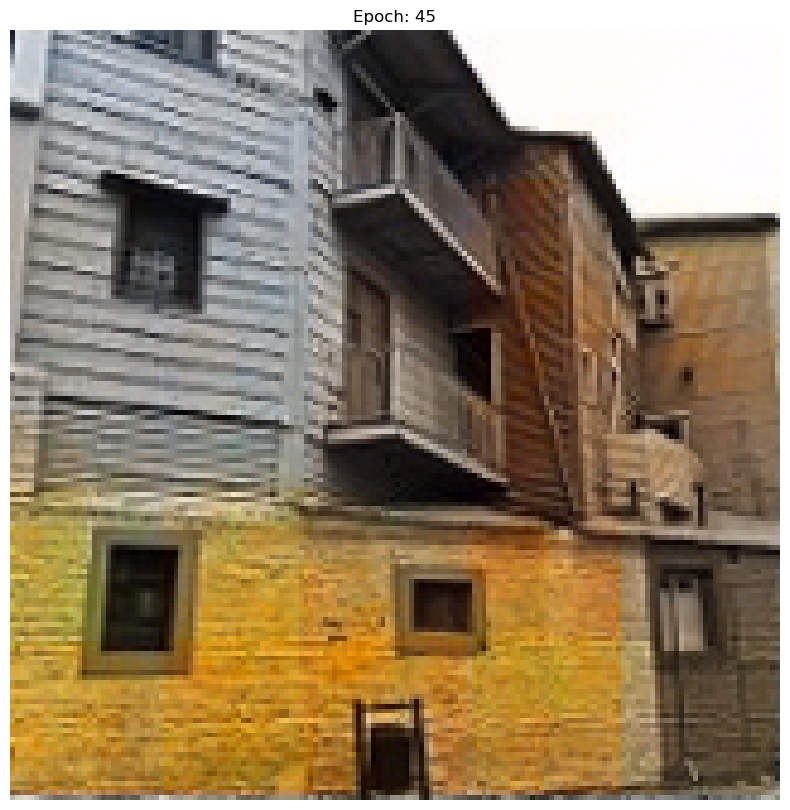

550/550 [==============================] - 25s 46ms/step - loss: 0.0255 - acc: 0.7470
Epoch 47/50
1/1 [==============================] - 0s 16ms/step- loss: 0.0253 - acc: 0.75


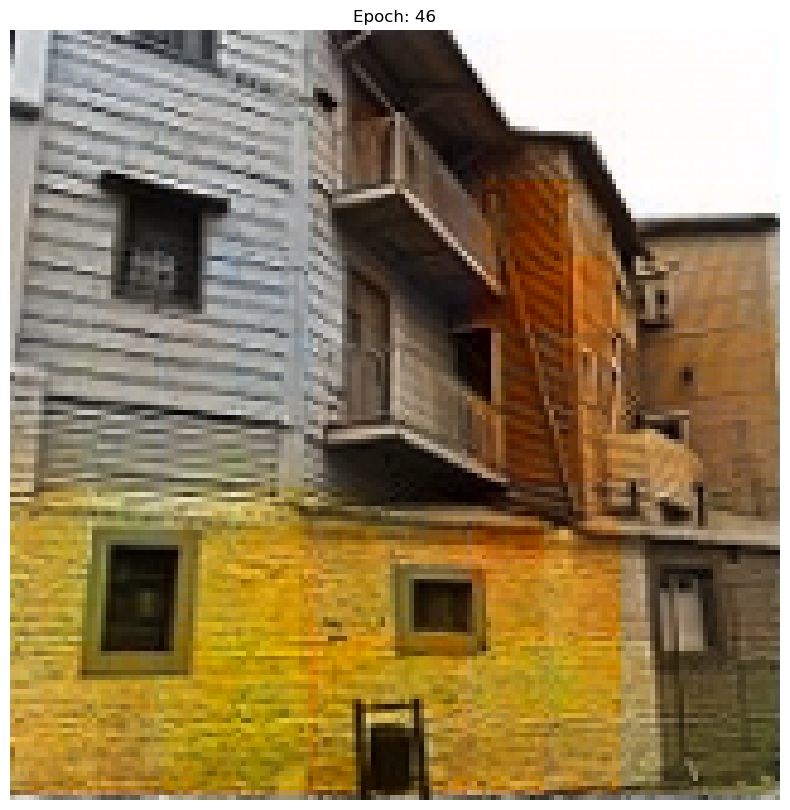

550/550 [==============================] - 26s 47ms/step - loss: 0.0253 - acc: 0.7511
Epoch 48/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0248 - acc: 0.75


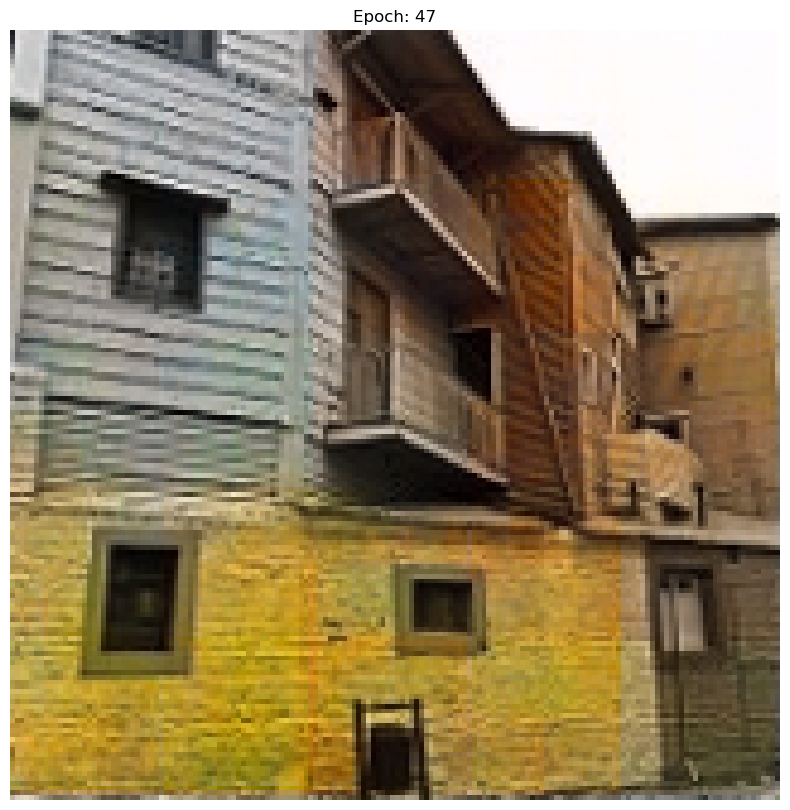

550/550 [==============================] - 26s 47ms/step - loss: 0.0248 - acc: 0.7522
Epoch 49/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0245 - acc: 0.75


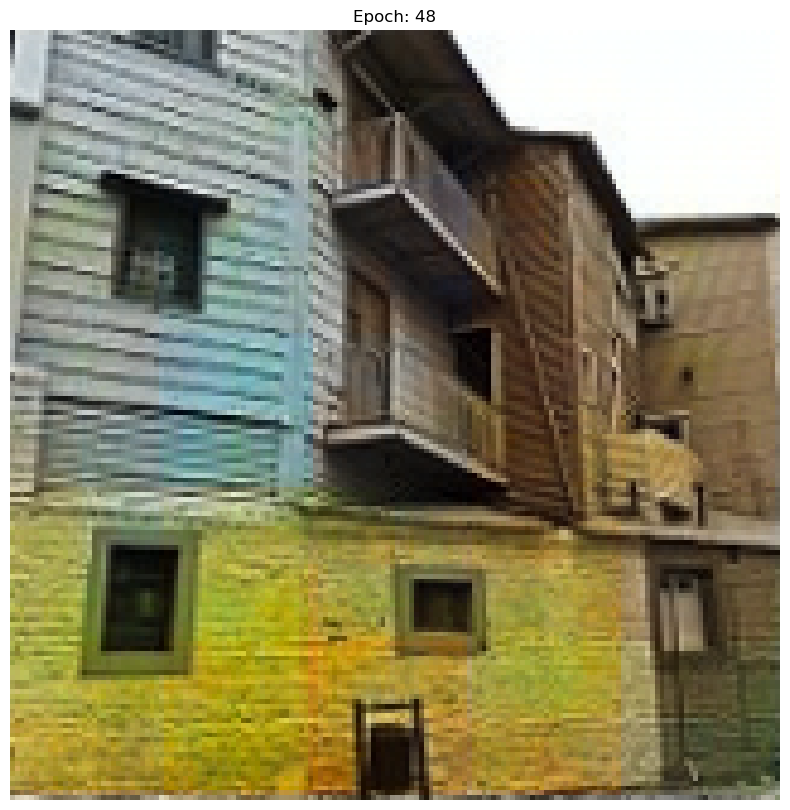

550/550 [==============================] - 26s 48ms/step - loss: 0.0245 - acc: 0.7569
Epoch 50/50
1/1 [==============================] - 0s 15ms/step- loss: 0.0243 - acc: 0.75


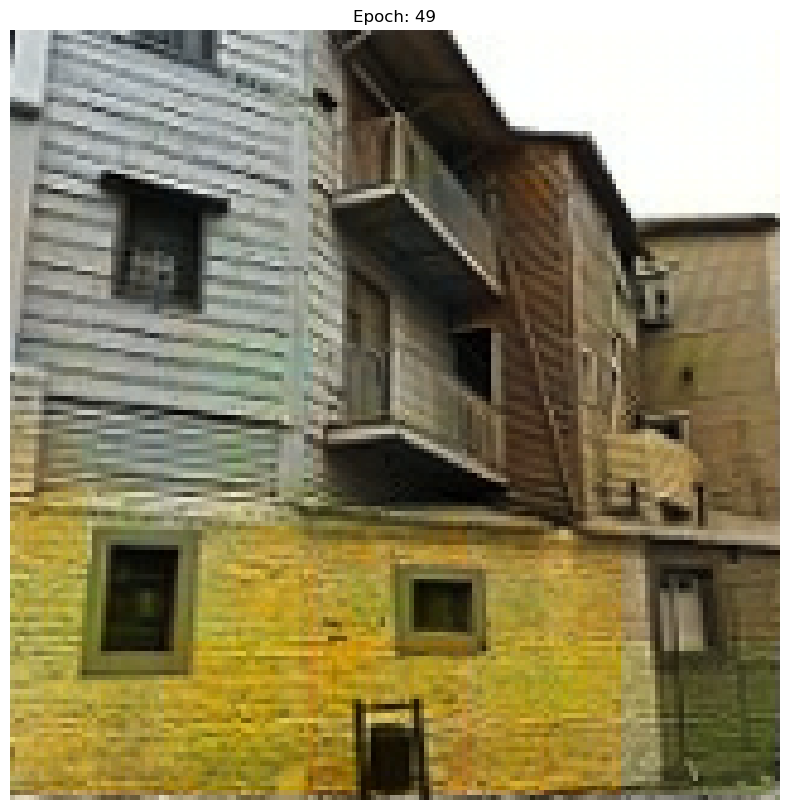

550/550 [==============================] - 26s 47ms/step - loss: 0.0242 - acc: 0.7586


In [13]:
model.fit(train_g, train_c, epochs = 50,batch_size = 10,verbose = 1, callbacks=[image_callback])

In [14]:
model.save("final_model_2.h5")

In [15]:
model = load_model(r'final_model.h5')

In [16]:
model.evaluate(test_gray_image,test_color_image, batch_size=20,)

NotFoundError: Graph execution error:

Detected at node 'model/sequential/conv2d/Conv2D' defined at (most recent call last):
    File "E:\Anaconda\envs\tensorflow\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\Anaconda\envs\tensorflow\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "E:\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "E:\Anaconda\envs\tensorflow\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "E:\Anaconda\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\IgorG\AppData\Local\Temp\ipykernel_25728\3059171916.py", line 1, in <module>
      model.evaluate(test_gray_image,test_color_image, batch_size=20,)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "E:\Anaconda\envs\tensorflow\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/sequential/conv2d/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16830592 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16830592 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 30601216 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 30601216 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 41252864 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 41252864 bytes.
	 [[{{node model/sequential/conv2d/Conv2D}}]] [Op:__inference_test_function_117798]

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(10,20):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [ ]:
model = load_model(r'final_model.h5')

In [ ]:
def single_predict(path, save=False):
    def plot_for_single(low,predicted):
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.title('Grey ', color = 'black', fontsize = 20)
        plt.imshow(low)
        plt.subplot(1,2,2)
        plt.title('Predicted', color = 'green', fontsize = 20)
        plt.imshow(predicted)

        plt.show()

    SIZE = 160
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0

    predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    plot_for_single(img, predicted)
    
    if save:
        file_name = 'predicted.jpg'
        cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))

In [ ]:
single_predict('6.jpg', 1)